# Module 2 Final Year Project

## Time Series Analysis of Real Estate  - Comparing New York City to San Francisco

There are 51 states in US, and it is a hectic task to deal with data in order to compare them.
So in order to minimise the complexity, the analysis was shortened to two states and the goal was set to provide insights and recommendations to those who are interested in learning what is the best return in real estate investment for a span of 2 and 5 years when deciding whether to buy on the East Coast in New York City, NY or in the West Coast in San Francisco, CA.

I will recommend, based on my analysis and modeling of historical data on real estate prices, obtained from the [Zillow Research Page](https://www.zillow.com/research/data/), what is the most sound financial decision, and I will also provide the 5 best zipcodes for buyers today in both cities for each investment time lag.


## Part I - Comparing San Francisco and NYC


### 1. Load libraries and data

We will start by loading all the necessary libraries, as well as our data from the file that has already been saved to this repository. 

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima
#from pyramid.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

In [2]:
# loading dataset
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [3]:
# checking how many unique values we have on each column, besides the time data
df.iloc[:,0:7].nunique()

RegionID      14723
RegionName    14723
City           7554
State            51
Metro           701
CountyName     1212
SizeRank      14723
dtype: int64

### 2. Preparing the Data

Looking at our dataframe we can see that the time data is formatted as columns. We have both RegionID and RegionName, and a quick research online shows that the column RegionName is the one that refers to zipcodes. Let's rename it accordingly.

In [4]:
# renaming column that refers to zipcodes
df.rename({'RegionName': 'Zipcode'}, axis='columns', inplace=True)
df.head()

RegionID  Zipcode      City State              Metro CountyName  SizeRank  \
0     84654    60657   Chicago    IL            Chicago       Cook         1   
1     90668    75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982    77494      Katy    TX            Houston     Harris         3   
3     84616    60614   Chicago    IL            Chicago       Cook         4   
4     93144    79936   El Paso    TX            El Paso    El Paso         5   

    1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
0  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800  1009600   
1  235700.0  236900.0  236700.0  ...   308000   310000   312500   314100   
2  210400.0  212200.0  212200.0  ...   321000   320600   320200   320400   
3  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400  1291500   
4   77300.0   77300.0   77300.0  ...   119100   119400   120000   120300   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
1   315000   316600   318100   319600   321100   321800  
2   320800   321200   321200   323000   326900   329900  
3  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

We also have data for the entire country. Let's filter out only what we will need - New York City and San Francisco.

In [5]:
# filtering only data for New York City and San Francisco
san_francisco = df.loc[df['City'] == 'San Francisco']
nyc = df.loc[df['City'] == 'New York']

In [6]:
san_francisco.head()

RegionID  Zipcode           City State          Metro     CountyName  \
9       97564    94109  San Francisco    CA  San Francisco  San Francisco   
76      97565    94110  San Francisco    CA  San Francisco  San Francisco   
333     97576    94122  San Francisco    CA  San Francisco  San Francisco   
504     97567    94112  San Francisco    CA  San Francisco  San Francisco   
742     97569    94115  San Francisco    CA  San Francisco  San Francisco   

     SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
9          10  766000.0  771100.0  776500.0  ...  3767700  3763900  3775000   
76         77  213900.0  214800.0  216000.0  ...  1503000  1506400  1513500   
333       334  278400.0  278300.0  278400.0  ...  1321100  1330500  1344600   
504       505  210100.0  210200.0  210300.0  ...   965200   979000   992700   
742       743  794000.0  796500.0  799000.0  ...  4157100  4140900  4145400   

     2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
9    3799700  3793900  3778700  3770800  3763100  3779800  3813500  
76   1525200  1533600  1536500  1536200  1544400  1570000  1594000  
333  1361500  1372100  1378900  1386500  1394100  1405000  1414800  
504  1005200  1012100  1014900  1016300  1019600  1027100  1033800  
742  4172600  4171100  4147900  4136800  4137200  4148900  4160500  

[5 rows x 272 columns]

We want to check how many unique zipcodes we have in each city.

In [7]:
# checking total number of zip codes for SF
print(f'We have {san_francisco.Zipcode.nunique()} different zip codes in our dataset for San Francisco.')

We have 19 different zip codes in our dataset for San Francisco.


In [8]:
# checking total number of zip codes for NY
print(f'We have {nyc.Zipcode.nunique()} different zip codes in our dataset for NYC.')

We have 114 different zip codes in our dataset for NYC.


Looks like we have a total of 133 unique zipcodes for our time series analysis. 

Our next step will be to use a function to transform our data from a wide format as it is now to a long format, and then make it into a pandas series of datetime object. We were provided with this helper function from our curriculum.

In [9]:
# create function to melt data and make it into time series

def melt_data(df):
    ''' 
    Takes a dataframe with datetime data that is in wide format and melts it into long format; 
    Tranforms data into datetime object with time as index.
    User will need to change columns names on first line of code according to their own dataframe.
    '''
    
    melted = pd.melt(df, id_vars=['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [10]:
# apply function to our data:
sf_ts = melt_data(san_francisco)
nyc_ts = melt_data(nyc)

In [11]:
sf_ts.head()

value
time                     
1996-04-01  394605.263158
1996-05-01  396078.947368
1996-06-01  397673.684211
1996-07-01  399410.526316
1996-08-01  401252.631579

Great, now our data is in a time series format with a DatetimeIndex and a column with our target values with a total of 252 datapoints, which correspond to 21 years. We can now move on to some visualizations of our data.

### 3. Visualizations

Now that we have our data in the right format for our two cities, let's start by looking at some visualizations to help us deepen our understanding and direct our analysis and modeling strategy.

Let's first of all do a quick visualization of this data, comparing both cities.

In [12]:
fig = go.Figure()
colorway = ['#f3cec9', '#e7a4b6', '#cd7eaf', '#a262a9', '#6f4d96', '#3d3b72', '#182844']
fig.add_trace(go.Scatter(x=sf_ts.index, y=sf_ts.value, name='San Francisco',
                        line_color='olive'))
fig.add_trace(go.Scatter(x=nyc_ts.index, y=nyc_ts.value, name='New York City',
                         line_color='gray'))
fig.update_layout(title_text='San Francisco & NYC Zillow Home Value Index',
                  colorway=colorway, xaxis_rangeslider_visible=True)
fig.show()

That is very interesting. We can see from our graph that the mean Zillow Home Value Index (ZHVI) for the city of San Francisco, CA is higher than that for New York City, NY. We can also note the trends in the data for both cities: overall continuously rising trend, with some drop following the 2007-2008 real estate crisis - less so for NYC than for San Francisco. At the same time, we note that the upward trend is steeper for San Francisco during the last years - which makes sense when one thinks of the impact that the technology companies have been causing in that area.

We also note a big straight jump in the data for NYC in 2004, and upon investigating we see that this is because several zipcodes were created in that year. This inconsistency could make our modeling and predictions less robust but at the same time we could lose important information by eliminating zipcodes that could be rentable today, so we will choose to keep it that way for now.

From simply inspecting our data we can tell it is not stationary (positive trend), but we can go further into evaluating our data for trends and seasonality. We will create a function to calculate and plot rolling statistics for mean and standard deviation, as well as perform a Dickey-Fuller test for stationarity.

In [13]:
# create function to plot time series with rolling mean and rolling variance, plus results from Dickey-Fuller test

def plot_roll(ts, name=''):
    
    '''Takes a time series and plots it along with its rolling mean and its rolling standard deviation.
    Calculates and prints results from Dickey-Fuller test.'''
    
    # Calculate rolling mean and rolling standard deviation:
    rolmean = ts.rolling(window = 6, center = False).mean()
    rolstd = ts.rolling(window = 6, center = False).std()
    
    # Plot original time series and its rolling mean/standard deviation
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ts.index, y=ts.value, name='Original',
                             line_color='blue'))
    fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean.value, name='Rolling Mean',
                             line_color='red'))
    fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd.value, name='Rolling Std',
                             line_color='green'))
    fig.update_layout(title_text=f'{name} Rolling Mean & Standard Deviation',
                      xaxis_rangeslider_visible=True)
    fig.show();
    
    #Perform Dickey-Fuller test:
    print (f'{name} Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['value'])

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return print(dfoutput)

In [14]:
# checking stationarity for San Francisco
sf_dfoutput = plot_roll(sf_ts, 'San Francisco')

San Francisco Results of Dickey-Fuller Test:
Test Statistic                  -0.416521
p-value                          0.907304
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [15]:
# checking stationarity for NYC
plot_roll(nyc_ts, 'New York')

New York Results of Dickey-Fuller Test:
Test Statistic                   0.573334
p-value                          0.986940
#Lags Used                       0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


From our rolling statistics plots we can note that even though we can't easily observe a trend or seasonality in our standard deviation, the mean is notably increasing so our data is clearly not stationary. Of course the results from the Dickey-Fuller tests also confirm this, for both cities. We will, further ahead, need to make it stationary in order to model it correctly.


We want to create a yearly dataframe so that we check for any seasonality throughout the years. For this we'll create a function that takes a time series and returns a plot with the yearly grouped data.

In [16]:
#Create a new DataFrame with yearly values stored in columns 

def plot_yearly_ts(ts, name='', boxplot=False):
    
    '''Function takes a time series and groups it into yearly intervals using Grouper;
    Creates a new dataframe where yearly values are into columns to faciliate plotting.
    Gives the option to create a boxplot instead of line plot, if parameter is passed as True.'''
    
    # group data by year and made into dataframe
    year_group = ts.groupby(pd.Grouper(freq ='A'))
    yearly = pd.DataFrame()
    for year, group in year_group:
        yearly[year.year] = group.values.ravel()
        
    # plot boxplot if option is True
    if boxplot:
        ax = yearly.boxplot(figsize = (18,10))
        ax.set_ylabel('Value($)')
        ax.set_xlabel('Year')
        plt.title(f'{name} Mean Zillow Home Value Index (ZHVI) - Yearly', fontsize=18);
        
   # otherwise plot line plot
    else:
        plt.figure(figsize = (14,10))
        ax = plt.subplot(111)
        # speficy colors for plots
        tableau20 = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.596078431372549, 0.8745098039215686, 0.5411764705882353), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (1.0, 0.596078431372549, 0.5882352941176471), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.7686274509803922, 0.611764705882353, 0.5803921568627451), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.8588235294117647, 0.8588235294117647, 0.5529411764705883), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529), (0.6196078431372549, 0.8549019607843137, 0.8980392156862745), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764)]
        # remove borders from plot
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        n_points = yearly.shape[0]
        for rank, year in enumerate(yearly):
            ax.plot(np.arange(n_points-(n_points-1), n_points+1), yearly[year].values, color=tableau20[rank], lw=2)
            plt.xlim(1, 12)
            y_pos = yearly[year].values[-1] 
            ax.text(n_points, y_pos, year, color=tableau20[rank], fontsize=12)
            ax.grid(which='major', axis='y', linestyle= "--", lw=0.5, color="black", alpha=0.3)
            ax.set_ylabel('Value($)')
            ax.set_xlabel('Month')
            plt.title(f'{name} Mean Zillow Home Value Index (ZHVI) - Yearly', fontsize=18)

In [17]:
# check data
sf_ts.head(), sf_ts.tail()

(                    value
 time                     
 1996-04-01  394605.263158
 1996-05-01  396078.947368
 1996-06-01  397673.684211
 1996-07-01  399410.526316
 1996-08-01  401252.631579,                    value
 time                    
 2017-12-01  2.103574e+06
 2018-01-01  2.111747e+06
 2018-02-01  2.120553e+06
 2018-03-01  2.134005e+06
 2018-04-01  2.146479e+06)

While trying to run our function we were getting errors and upon investigating our data further, we noticed that both years 1996 and 2018 are not complete years, so we will filter out these years and keep only the years that have full monthly data for the yearly plots. 

In [18]:
# filter out years that are not complete
sf_ts_filter = sf_ts['1997':'2017']
nyc_ts_filter = nyc_ts['1997':'2017']

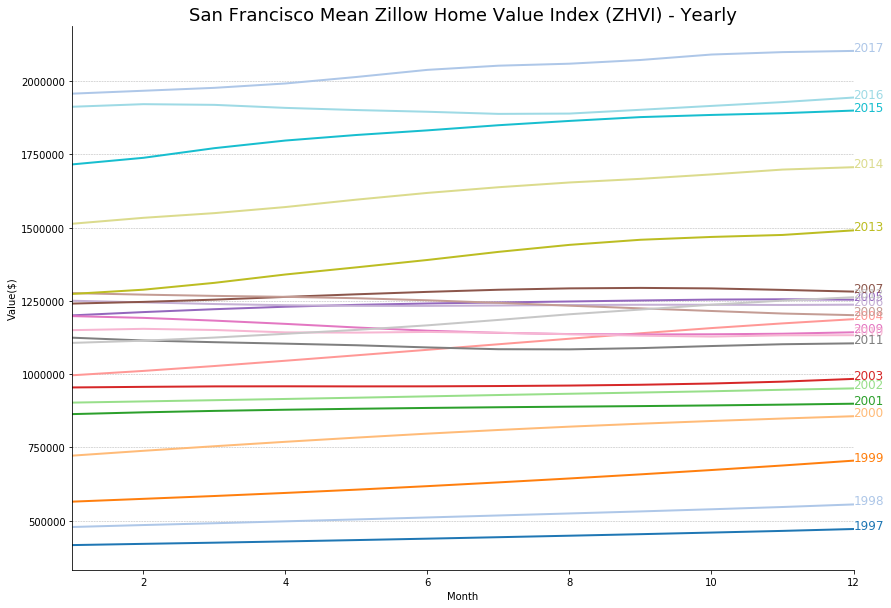

In [19]:
# plot yearly data for San Francisco
plot_yearly_ts(sf_ts_filter, 'San Francisco')

That is a lot of data in one plot, but it is useful to note a few things. We can't observe any clear seasonality in the yearly data, and we can see that the mean steadily moves up as the years increase, as we were able to observe in the previous plot, except for the years between 2009 and 2011 which reflect the impact of the financial crisis. Let's do a second visualization of only those years during the housing bubble crisis.

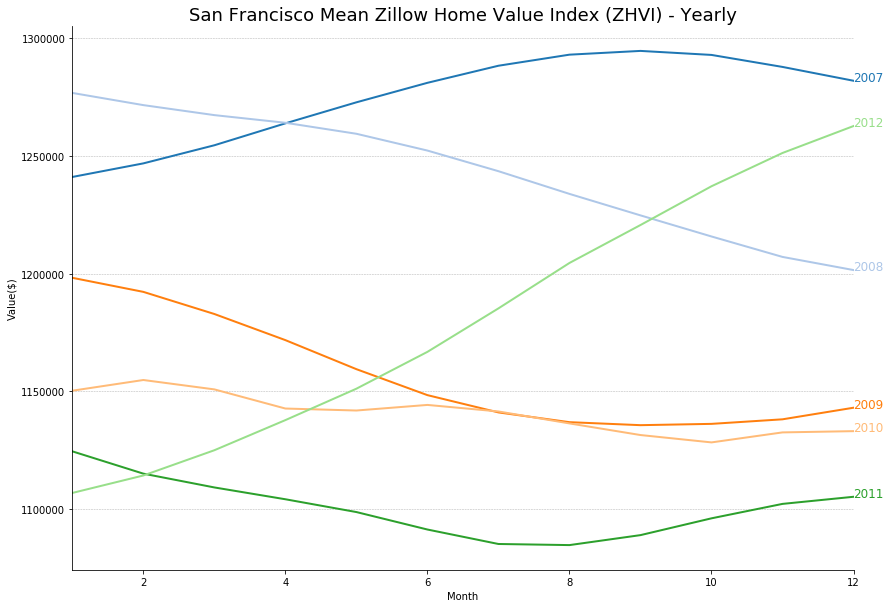

In [20]:
# plot other years for San Francisco for the time of the financial crisis
plot_yearly_ts(sf_ts_filter['2007':'2012'], 'San Francisco')

Here in this plot we can see that, starting at the end of 2007 home values started to fall and continued to do so  for the next 4 years, until about the end of 2011 when the trend starts to move up again. It was a slow fall and a quick recovery - values were at the lowest around August 2011 and by the end of 2012 house values are almost at the same level they were at the start of the crisis.

Let's also look at the boxplots for this data.

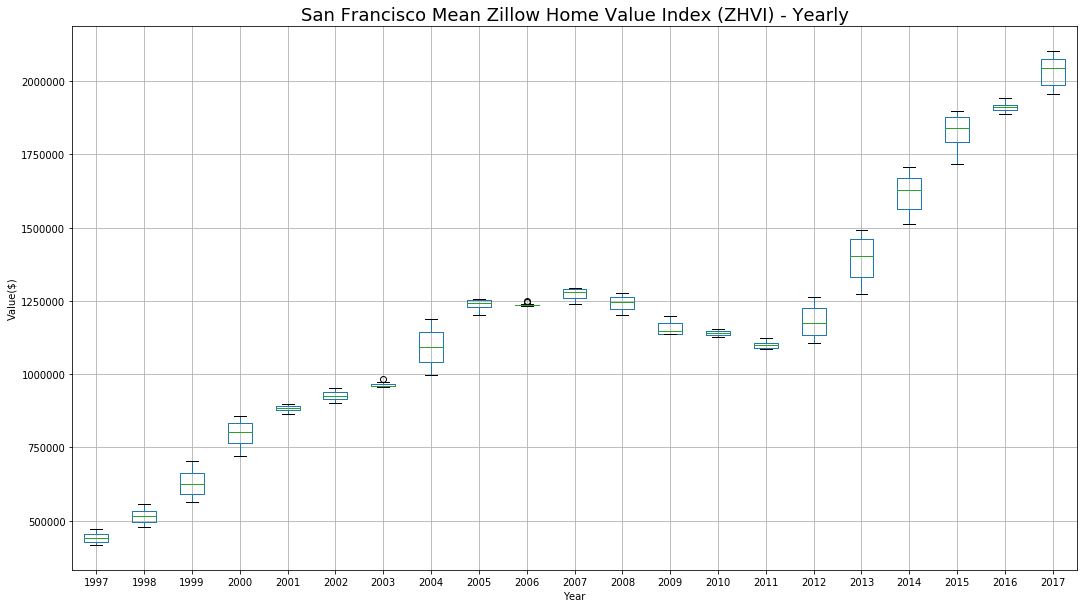

In [21]:
# plot boxplots for San Francisco
plot_yearly_ts(sf_ts_filter, 'San Francisco', boxplot=True)

The boxplot further confirms that there is a positive trend in the data. It also shows that the data variance is not changing by much year by year, and there is less variance coinciding with the years with more of a flat trend. We can again see that the mean is rising, except for the years between 2008 and 2011. There are also not many outliers in our data.  

Let's also have a look at New York City.

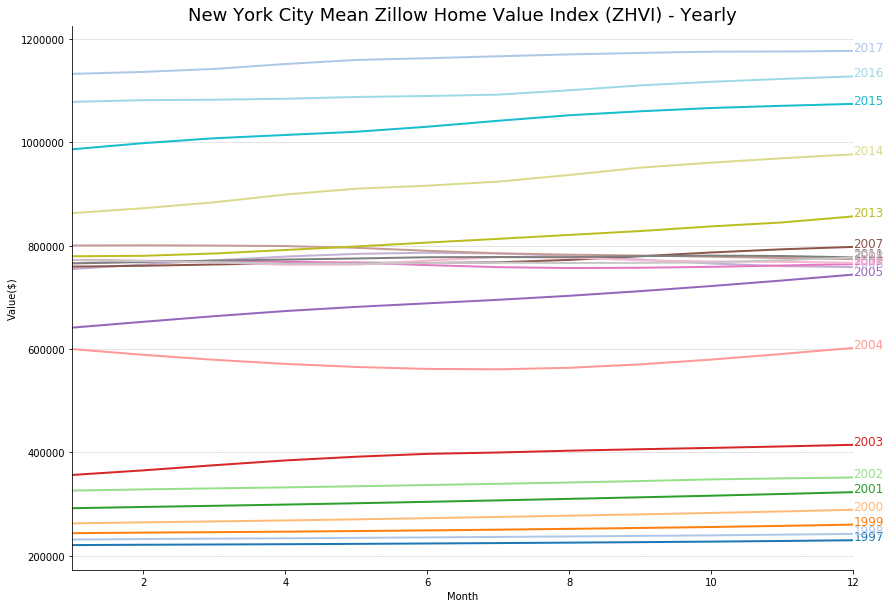

In [22]:
# plot yearly data for NYC 
plot_yearly_ts(nyc_ts_filter, 'New York City')

Again we see that there doesn't seem to be any clear seasonality in our data. As with San Francisco, the values steadily increase except for the period between 2006 and 2012 when values are much closer together. Let's again have a zoomed up look at these years only.

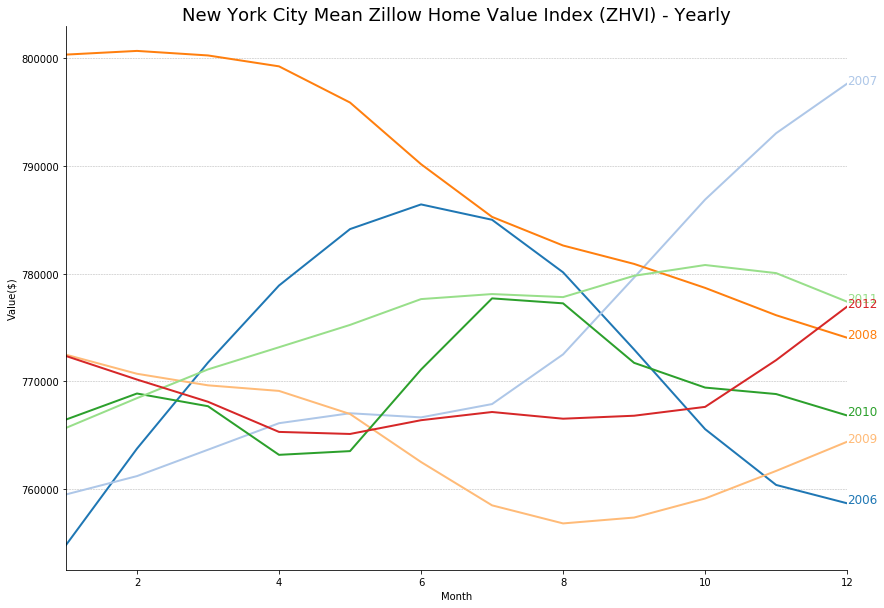

In [23]:
# plot other years data for NYC
plot_yearly_ts(nyc_ts_filter['2006':'2012'], 'New York City')

What we can obserse is that for NYC the effects of the housing crisis were less steady. We see how by middle of 2006 prices were rising up (as it was with the bubble for most locations) and then start to fall quickly, but by end of 2007 values were rising again, only to fall in 2008 - but never as low as they were in the end of 2006. By 2013 the recovery is clear and seems exponential. Overall this tells us that house values in NYC fared better during the crisis overall than that of San Francisco.

Let's also look at the boxplot for the New York City data.

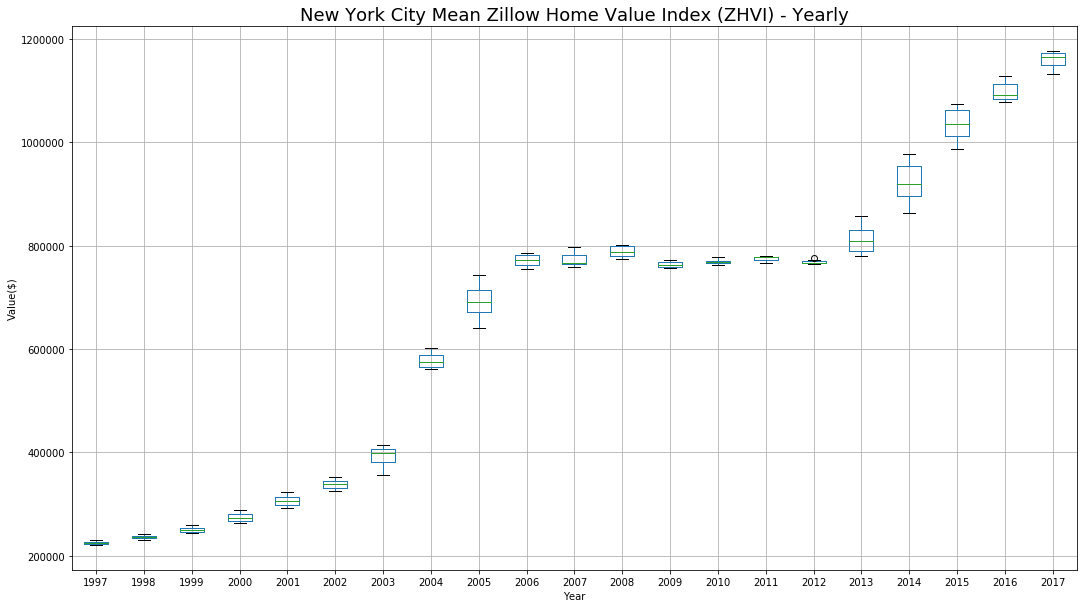

In [24]:
# plot boxplots for NYC
plot_yearly_ts(nyc_ts_filter, 'New York City', boxplot=True)

The New York City data looks similar, and we can note that the financial crisis had less impact for NYC. The values steadily rise from year to year with some stagnation in the wake of the house bubble crisis, from years 2009 to 2012. 

### 4. Calculate Returns Statistics

We want to create some statistics to help us better evaluate returns and eventual losses in times of crises for both cities, which is what our stakeholders are interested in. 

We'll create a function in order to do that. Our function will calculate what was the percentage gain over amount invested in a lag of 2, 5 and 10 years previous, throughout the time, plot and return the information as dataframes for further investigation and modeling.

In [25]:
# function to calculate gain percentage (ROI) on previous 2, 5 and 10 years
def calculate_gain(ts, plot=True):
    
    '''Takes a real estate time series and performs calculations on returns over investments
    for periods of 2, 5 and 10 years.'''
    
    # calculates ROI by taking current value, decreasing investment(value at x steps in past) and 
    # dividing by investment. Multiplies by 100 to get percentage number
    roi_2 = (ts - ts.shift(periods=24))/ts.shift(periods=24)*100
    roi_5 = (ts - ts.shift(periods=60))/ts.shift(periods=60)*100
    roi_10 = (ts - ts.shift(periods=120))/ts.shift(periods=120)*100
    roi_2.dropna(inplace=True)
    roi_5.dropna(inplace=True)
    roi_10.dropna(inplace=True)
    
    # plot results
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=roi_2.index, y=roi_2.value, name='2-Year Investment',
                                 line_color='deepskyblue'))
        fig.add_trace(go.Scatter(x=roi_5.index, y=roi_5.value, name='5-Year Investment',
                                 line_color='red'))
        fig.add_trace(go.Scatter(x=roi_10.index, y=roi_10.value, name='10-Year Investment',
                                 line_color='gray'))
        fig.update_layout(title_text='Mean Zillow Home Value Index (ZHVI) - ROI Over Time Invested',
                          xaxis_rangeslider_visible=True)
        fig.show()
    
    # saves new ts with returns for 2, 5 and 10 periods
    return roi_2, roi_5, roi_10

In [26]:
# let's call the function to examine San Francisco's data first
sf_roi2, sf_roi5, sf_roi10 = calculate_gain(sf_ts)

Not surprisingly, the returns for investment with a time lag of 10 years are potentially the highest - they peaked at just over 200% at around 2007 in San Francisco for the people who had bought 10 years before. It is also at the highest fluctuation, as it comes down quickly form over 200% to around 20% in a span of approximately 5 years. It is however always a positive return, never under 20% even at the height of financial crisis.

On the other hand, on a 2 and 5 lag investment, there is loss during the financial crisis, from around 2008 to 2012-2013, that reaches a little over 12% of loss. Once over the crisis the gains rise again, but are now in what looks a downward trend. 

Let's see how NYC fares.

In [27]:
nyc_roi2, nyc_roi5, nyc_roi10 = calculate_gain(nyc_ts)

In NYC one thing we notice is the effect of that quick drop that shows the period in time (around 2004) with the creation of new zipcodes. Regardless of this, what we can see is that investing in NYC has rarely represented a loss, even at the peak of the housing crisis as we have only a short period of loss around 2010 and 2013. The returns on 10 year-investments also seem highest for NYC, reaching over 260% at the initial point, and even at the lowest return in 10-years it is around 40% and thus higher when compared to the lowest 10-year return for San Francisco (of around 20%).

New York also seems to be starting to have a downward trend in terms of return of investment, although it doesn't seem as pronounced as for San Francisco.

We want to further compare the returns for both cities, side-by-side. We'll create a quick function to return the max and min return for each city for each investment lag.

In addition we want to plot the cities side-by-side so that we can better visualize and compare their performances.

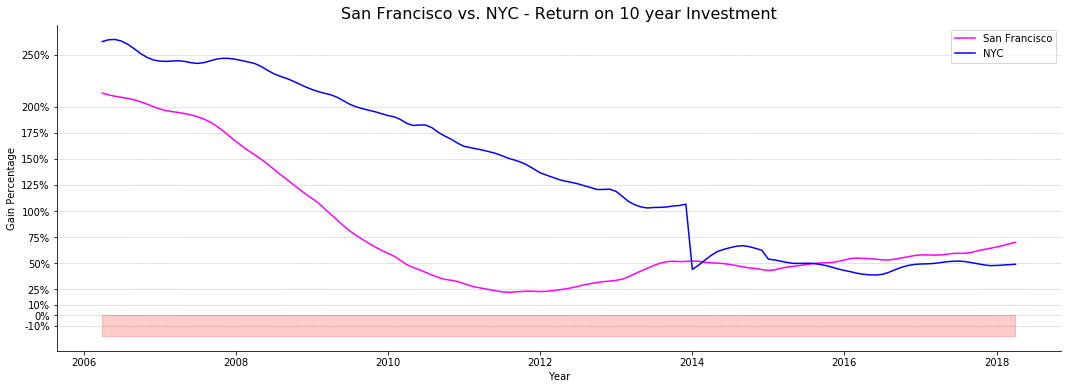

In [28]:
# create visualization of both time series:
plt.figure(figsize=(18,6))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.plot(sf_roi10, label='San Francisco', color='magenta')
ax.plot(nyc_roi10, label='NYC', color='blue')
ax.fill_between(sf_roi10.index, sf_roi10.value<0, -20, color='red', alpha=.2)
plt.title('San Francisco vs. NYC - Return on 10 year Investment', fontsize=16)
ax.set_ylabel('Gain Percentage')
ax.set_xlabel('Year')
plt.yticks([-10,0,10,25,50,75,100,125,150,175,200, 250], [str(x) + "%" for x in [-10,0,10,25,50,75,100,125,150,175,200, 250]], fontsize=10)
ax.grid(which='major', axis='y', linestyle= "--", lw=0.5, color="black", alpha=0.3)
ax.legend()
plt.show();

It looks like over time investing in NYC has brought higher returns, and this only reverses more recently, from around 2015, which is a clear reflection of the current real estate situation in San Francisco, where there is a big housing shortage following the tech and Internet job boom in that area. From [Wikipedia](https://en.wikipedia.org/wiki/San_Francisco_housing_shortage): "from 2012 to 2016, the San Francisco metropolitan area added 373,000 new jobs, but permitted only 58,000 new housing units."

Even so, the return in investment for both cities is very close at current times. However, we must point out that the mean house price for New York City is less than for San Francisco, meaning that less money invested is needed. Let's see how they compare for 2-year and 5-year investments over time.

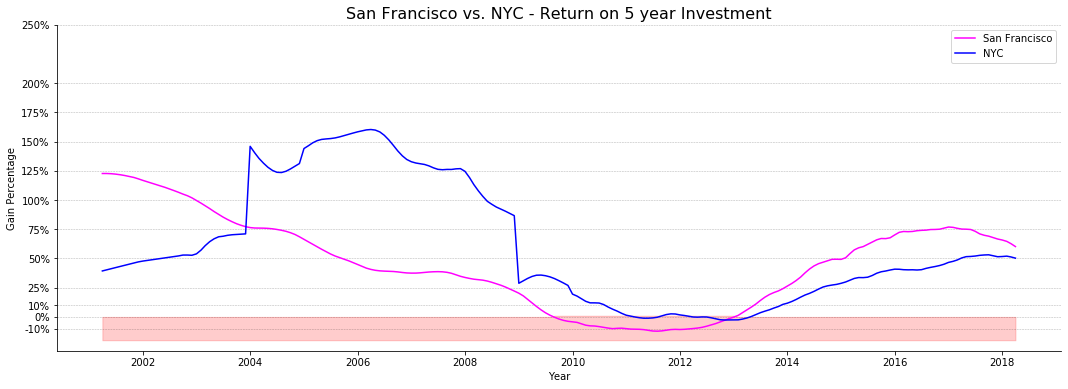

In [29]:
# create visualization of both time series:
plt.figure(figsize=(18,6))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.plot(sf_roi5, label='San Francisco', color='magenta')
ax.plot(nyc_roi5, label='NYC', color='blue')
ax.fill_between(sf_roi5.index, sf_roi5.value<0, -20, color='red', alpha=.2)
plt.title('San Francisco vs. NYC - Return on 5 year Investment', fontsize=16)
ax.set_ylabel('Gain Percentage')
ax.set_xlabel('Year')
plt.yticks([-10,0,10,25,50,75,100,125,150,175,200, 250], [str(x) + "%" for x in [-10,0,10,25,50,75,100,125,150,175,200, 250]], fontsize=10)
ax.grid(which='major', axis='y', linestyle= "--", lw=0.5, color="black", alpha=0.3)
ax.legend()
plt.show();

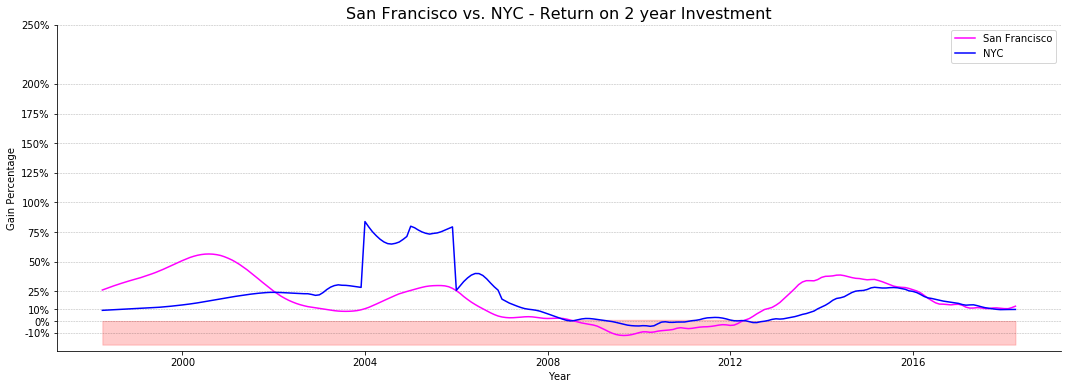

In [30]:
# create visualization of both time series:
plt.figure(figsize=(18,6))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.plot(sf_roi2, label='San Francisco', color='magenta')
ax.plot(nyc_roi2, label='NYC', color='blue')
ax.fill_between(sf_roi2.index, sf_roi2.value<0, -20, color='red', alpha=.2)
plt.title('San Francisco vs. NYC - Return on 2 year Investment', fontsize=16)
ax.set_ylabel('Gain Percentage')
ax.set_xlabel('Year')
plt.yticks([-10,0,10,25,50,75,100,125,150,175,200, 250], [str(x) + "%" for x in [-10,0,10,25,50,75,100,125,150,175,200, 250]], fontsize=10)
ax.grid(which='major', axis='y', linestyle= "--", lw=0.5, color="black", alpha=0.3)
ax.legend()
plt.show();

What we can see from both plots is that San Francisco started out in our time frame as a better investment, was overtaken by NYC right before the crisis, and are now more comparable, especially on a 2-year lag. 

Let's do a little side-by-side comparison for highest and lowest returns for each city so that we can more easily see which is the city that shows the best returns and smaller losses. I'll make another function to get this statistics comparison in an easy to read format.

In [31]:
def compare_gain(ts1, ts2, name='', name2='', plot=True):
    
    '''Takes two time series, calculates returns in 2, 5 and 10 years for each 
    and returns max and min values for each'''
    
    # calculates returns for first time series
    ts1.dropna(inplace=True)
    ts1_roi_2, ts1_roi_5, ts1_roi_10 = calculate_gain(ts1, plot=False)

    
    # calculates returns for second time series
    ts2.dropna(inplace=True)
    ts2_roi_2, ts2_roi_5, ts2_roi_10 = calculate_gain(ts2, plot=False)
    
    # organize returns values and make into dataframes
    hist_roi = {}
    hist_roi[name] = {}
    hist_roi[name]['Max Return 02-Year'] = round(ts1_roi_2.values.max(),2)
    hist_roi[name]['Min Return 02-Year'] = round(ts1_roi_2.values.min(),2)
    hist_roi[name]['Max Return 05-Year'] = round(ts1_roi_5.values.max(),2)
    hist_roi[name]['Min Return 05-Year'] = round(ts1_roi_5.values.min(),2)
    hist_roi[name]['Max Return 10-Year'] = round(ts1_roi_10.values.max(),2)
    hist_roi[name]['Min Return 10-Year'] = round(ts1_roi_10.values.min(),2)
    
    hist_roi[name2] = {}
    hist_roi[name2]['Max Return 02-Year'] = round(ts2_roi_2.values.max(),2)
    hist_roi[name2]['Min Return 02-Year'] = round(ts2_roi_2.values.min(),2)
    hist_roi[name2]['Max Return 05-Year'] = round(ts2_roi_5.values.max(),2)
    hist_roi[name2]['Min Return 05-Year'] = round(ts2_roi_5.values.min(),2)
    hist_roi[name2]['Max Return 10-Year'] = round(ts2_roi_10.values.max(),2)
    hist_roi[name2]['Min Return 10-Year'] = round(ts2_roi_10.values.min(),2)
    
    last_roi = {}
    last_roi[name] = {}
    last_roi[name]['Mean 6M Investment'] = round(ts1.iloc[-7:-1].values.mean(),0)
    last_roi[name]['Mean 6M Return 02-Year'] = round(ts1_roi_2.iloc[-7:-1].values.mean(),2)
    last_roi[name]['Mean 6M Return 05-Year'] = round(ts1_roi_5.iloc[-7:-1].values.mean(),2)
    last_roi[name]['Mean 6M Return 10-Year'] = round(ts1_roi_10.iloc[-7:-1].values.mean(),2)
    
    last_roi[name2] = {}
    last_roi[name2]['Mean 6M Investment'] = round(ts2.iloc[-7:-1].values.mean(),0)
    last_roi[name2]['Mean 6M Return 02-Year'] = round(ts2_roi_2.iloc[-7:-1].values.mean(),2)
    last_roi[name2]['Mean 6M Return 05-Year'] = round(ts2_roi_5.iloc[-7:-1].values.mean(),2)
    last_roi[name2]['Mean 6M Return 10-Year'] = round(ts2_roi_10.iloc[-7:-1].values.mean(),2)
           
    hist = pd.DataFrame.from_dict(hist_roi)
    last = pd.DataFrame.from_dict(last_roi)
    complete = pd.concat([hist, last])
    
    
    # plot results
    if plot:
        my_colors = [(x/10.0, x/20.0, 0.75) for x in range(1,12)]
        ax = complete.loc[['Mean 6M Investment'], :].plot(kind='bar', colormap='Accent', figsize=(8,6))
        ax.set_xlabel('Mean 6M Investment')
        ax.set_xticks([])
        plt.title('Mean Last 6 Months Investment', fontsize=16)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        
        gains = complete.drop(['Mean 6M Investment','Mean 6M Return 02-Year','Mean 6M Return 05-Year','Mean 6M Return 10-Year'], axis=0)
        ax = gains.plot(kind='bar', colormap='Accent', figsize=(12,8))
        plt.gcf().autofmt_xdate()
        plt.title('Historical Returns', fontsize=16)
        plt.axhline(y=0, color='red', alpha=.5)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        
        ax = complete.loc[['Mean 6M Return 02-Year','Mean 6M Return 05-Year','Mean 6M Return 10-Year'], :].plot(kind='bar', colormap='Accent', figsize=(8,6))
        plt.gcf().autofmt_xdate()
        plt.title('Mean Last 6 Months Return', fontsize=16)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)

    
    return complete 
    

In [32]:
sf_ts.tail(6)

value
time                    
2017-11-01  2.099442e+06
2017-12-01  2.103574e+06
2018-01-01  2.111747e+06
2018-02-01  2.120553e+06
2018-03-01  2.134005e+06
2018-04-01  2.146479e+06

San Francisco  New York City
Max Return 02-Year              56.50          83.85
Min Return 02-Year             -12.27          -4.52
Max Return 05-Year             122.66         160.28
Min Return 05-Year             -12.24          -2.66
Max Return 10-Year             213.08         264.60
Min Return 10-Year              22.00          38.54
Mean 6M Investment         2110089.00     1180506.00
Mean 6M Return 02-Year          10.77           9.76
Mean 6M Return 05-Year          66.08          51.96
Mean 6M Return 10-Year          64.91          48.22

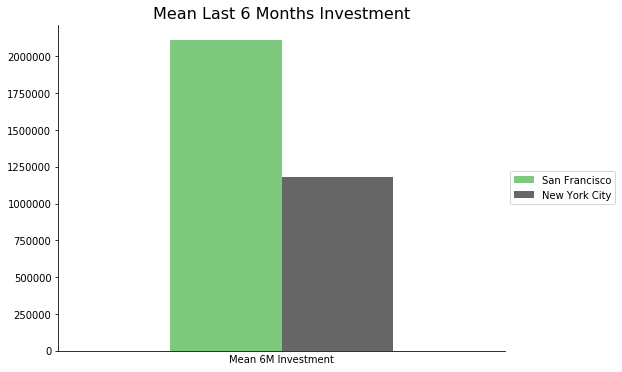

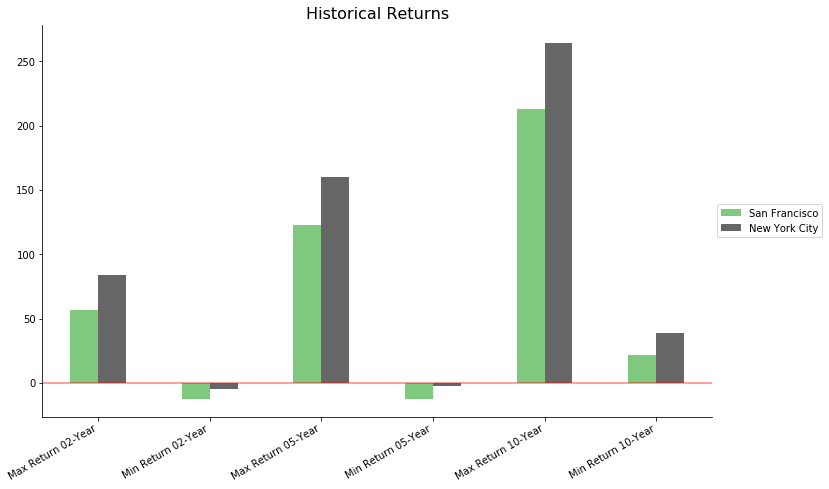

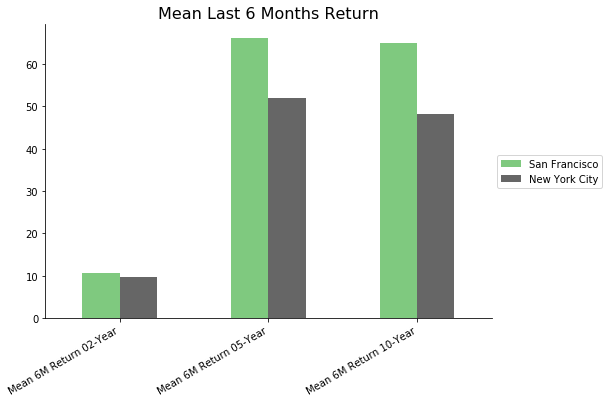

In [33]:
compare_gain(sf_ts, nyc_ts, name='San Francisco', name2='New York City')

From this comparison data, New York is historically the best option to invest, regardless of the time-lag for the investment as it has provided the highest return rate and smaller loss when that is the case for all time options: 2, 5 and 10-year investments. It also requires less capital invested. 

However, the return in the last period of our data, the month of 2007 were higher for San Francisco. In any case, we want to model the returns data so that we can see what the prediction is for the future in terms of not only house price but rather of returns over investment, and if the trend is favorable to investing in San Francisco, despite the history showed by the data.



### 5. Modeling

Our stakeholders are interested in investing with a 2 and 5 year return, so we will only work with these two series for our modeling and prediction. In any case, predictions for over 5 years would be too far ahead and not reliable (have a too wide confidence interval).

As a first step in our modeling process, we will create a function to calculate and plot both the Autocorrelation (ACF) and the Partial Autocorrelation (PACF) for our data, which will be helpful with some initial idea for difference order we might use, as well as the other parameters of our model. Let's also check our returns data for stationarity.

In [34]:
# checking stationarity 
returns = [sf_roi2, sf_roi5, nyc_roi2, nyc_roi5]
names = ['San Francisco 2-Year', 'San Francisco 5-Year', 'NYC 2-Year', 'NYC 5-Year']
for ts, name in zip(returns, names):
    plot_roll(ts, name=name)

San Francisco 2-Year Results of Dickey-Fuller Test:
Test Statistic                  -2.673356
p-value                          0.078763
#Lags Used                      15.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


San Francisco 5-Year Results of Dickey-Fuller Test:
Test Statistic                  -2.535463
p-value                          0.107082
#Lags Used                      15.000000
Number of Observations Used    189.000000
Critical Value (1%)             -3.465431
Critical Value (5%)             -2.876957
Critical Value (10%)            -2.574988
dtype: float64


NYC 2-Year Results of Dickey-Fuller Test:
Test Statistic                  -1.919955
p-value                          0.322733
#Lags Used                       0.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


NYC 5-Year Results of Dickey-Fuller Test:
Test Statistic                  -0.989214
p-value                          0.757178
#Lags Used                       0.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


Most of our data is not stationary and this means we will need to difference it by at least order 1 in order to better fit a model. However, we note that the spike with the creation of new zipcodes in NYC in 2004 is causing our data to look very inconsistent and this might be prejudicial to our modeling. We want to remove this data impacted so as to not confuse our models, and work with only the years after such impact - 2006 for the 2-Year data, and 2009 for the 5-Year data. Let's remove this and plot the rolling statistics again for NYC.

In [35]:
# filtering out inconsistent data for New York City
nyc_roi2 = nyc_roi2['2007':]
nyc_roi5 = nyc_roi5['2009':]

# save variable again to make sure we have the current time series for NYC
returns = [sf_roi2, sf_roi5, nyc_roi2, nyc_roi5]

In [36]:
plot_roll(nyc_roi2, 'New York 2-Year')

New York 2-Year Results of Dickey-Fuller Test:
Test Statistic                  -2.119327
p-value                          0.236814
#Lags Used                       6.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [37]:
plot_roll(nyc_roi5, 'New York 5-Year')

New York 5-Year Results of Dickey-Fuller Test:
Test Statistic                  -0.798447
p-value                          0.819578
#Lags Used                       1.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


 That is much better. Let's look at all ACF and PACF plots. We will create a function to take a time series and plot both ACF and PACF at once.

In [38]:
# create function to plot ACF and PACF
def acf_pacf(ts,alags=40,plags=40):
    '''Takes timeseries and plots ACF and PACF'''
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
    plot_acf(ts,lags=alags, zero=True,ax=ax1)
    plot_pacf(ts,lags=plags, ax=ax2, method = 'ywmle')
    plt.show();


 
 San Francisco 2-Year 



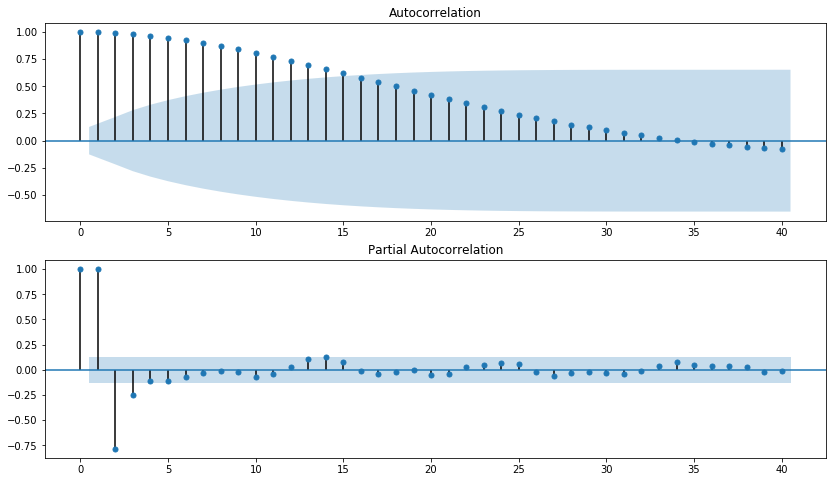


 
 San Francisco 5-Year 



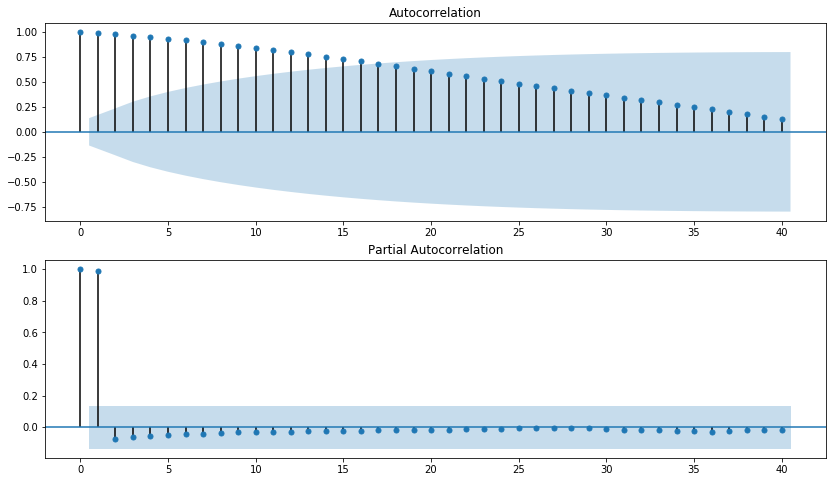


 
 NYC 2-Year 



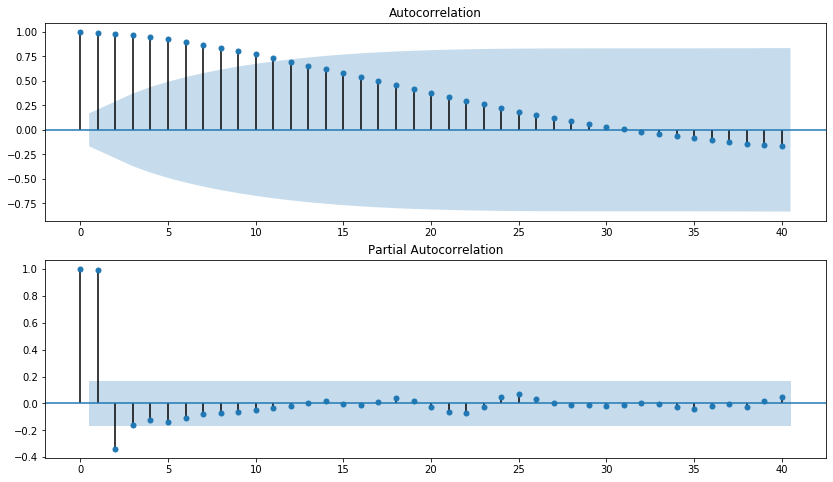


 
 NYC 5-Year 



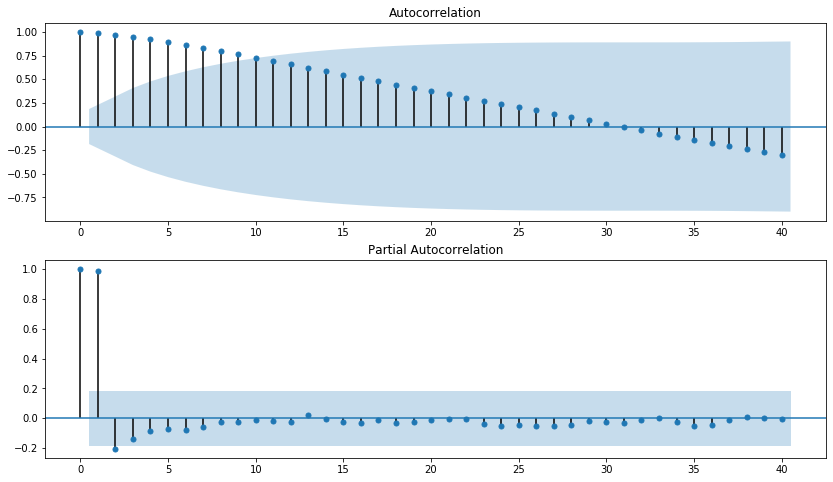

In [39]:
# checking ACF and PACF plots  
for ts, name in zip(returns, names):
    print(f'\n \n {name} \n')
    acf_pacf(ts)

We can see on our ACF plots that for most data there is a significant positive correlation up to around 15 lags, which is expected for this type of data such as real estate values. This will instruct us on what could be a good order for our MA parameter. 

On our PACF plots we see that we might be dealing with an AR order 1 or 2 for most data. 

We also want to decompose the data so that we can note if there is any seasonality that we can't observe clearly.

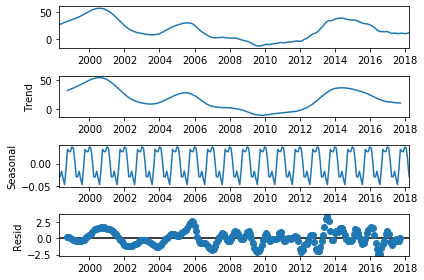

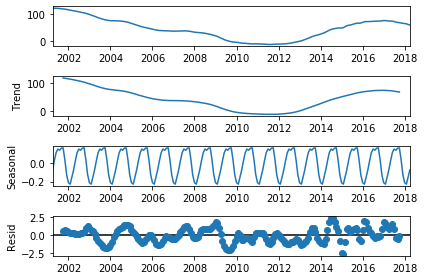

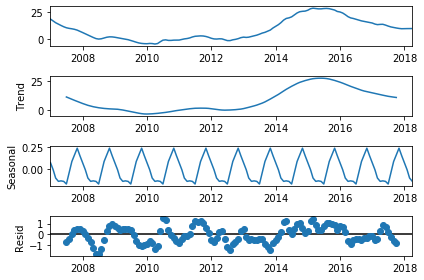

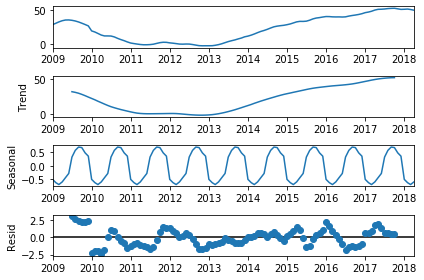

In [40]:
# decompose time series
for df in returns:
    result = seasonal_decompose(df, model='additive')
    result.plot()

It looks like indeed there is some seasonality for all the data, so we will keep this in mind. We will work with a SARIMAX model to account for all factors. As a first step we will work with the data for San Francisco 2-year Returns for a test, and run an initial model as our base, using order 1 for all parameters and s=12.

In [41]:
def fit_sarimax_model(ts, order=(1,1,1), seasonal_order=(0, 0, 0, 12), summary=True, plot=True):
    
    '''Takes a time series and runs a SARIMAX model with parameter order provided. 
    If no parameter provided default is (1,1,1), (0,0,0,12). 
    Has the default option to print model summary and plot diagnostics, which can be turned off'''
  
    # fit model
    model = sm.tsa.statespace.SARIMAX(ts,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    trend='ct',
                                    enforce_stationarity=True,
                                    enforce_invertibility=False)
    output = model.fit(d=0)
    
    if summary==True:
        print(output.summary())

    if plot==True:
        # plot model diagnostics
        output.plot_diagnostics(figsize=(15, 18))
        plt.show()
        
    return output

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -53.535
Date:                Sat, 02 May 2020   AIC                            117.070
Time:                        20:47:18   BIC                            134.473
Sample:                    04-01-1998   HQIC                           124.082
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0124      0.078     -0.160      0.873      -0.164       0.140
drift          0.0001      0.000      0.242      0.808      -0.001       0.001
ar.L1          0.8998      0.027     33.140      0.0

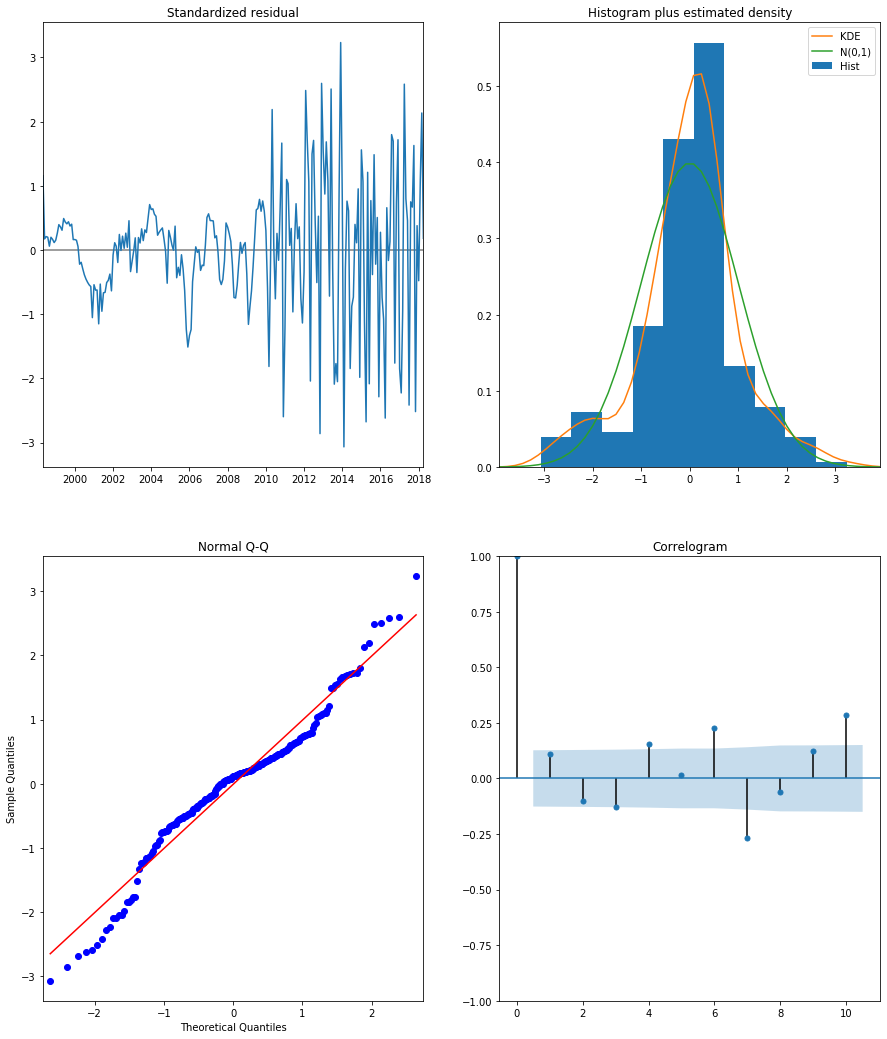

In [42]:
sf2_output = fit_sarimax_model(sf_roi2)

We can see from our diagnostics that our residuals are not quite normally distributed, and show some correlation so that means our model is far from ideal and we must work to improve it. That makes sense since this was a basic, initial model.

Let's get predictions and the RMSE for this model so that we have some comparison ahead. We will again create a function to make this step easily replicated.

In [43]:
def get_predictions(ts, model_output, steps=24, plot=True, show=True):
    
    '''Gets one-step-ahead forecast for model, 
    calculates Root of Mean Squared Error, 
    makes future predictions for number
    of steps passed as parameter(default is 24), 
    plots results, 
    provides last forecasted value with confidence interval'''

    
    # get preditions from model for data period
    pred = model_output.get_prediction(start='2016-01-01', dynamic=True, full_results=True)
    conf = pred.conf_int()
    
    if plot:
        #Plot observed and predicted values with confidence interval
        ax = ts['2014':].plot(label='Observed', figsize=(12, 8))
        pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
        ax.fill_between(conf.index,
                        conf.iloc[:, 0],
                        conf.iloc[:, 1], color='g', alpha=.2,
                        label='Confidence Interval')
        ax.set_ylabel('Return %')
        plt.title('Observations vs Predictions')
        ax.legend()
        plt.show()

    # compare real and predicted values to validade model and compute the rmse
    predicted = pred.predicted_mean
    real = ts['2016-01-01':].value
    mse = mean_squared_error(real, predicted)
    rmse = math.sqrt(mse)
    
    if show:
        print(f'The RMSE of our forecast is {round(rmse, 2)}.' + '\n')
        
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, dynamic=True)
    future_conf = future.conf_int(steps=steps)

    if plot:
        # plot results
        ax = ts['2014':].plot(label='Observed', figsize=(12, 8))
        future.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(future_conf.index,
                        future_conf.iloc[:, 0],
                        future_conf.iloc[:, 1], color='k', alpha=.25)
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns')
        ax.legend()
        plt.show()

    # show prediction for end of step-period (in this case in 2 years future time)
    forecast = future.predicted_mean[-1]
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    predictions = {}
    predictions['forecast'] = forecast
    predictions['maximum'] = maximum
    predictions['minimum'] = minimum
    
    predictions = pd.DataFrame.from_dict(predictions, orient='index', columns=['Return at End of Forecast'])
    
    if show:
        print(predictions)
        
    return forecast, maximum, minimum

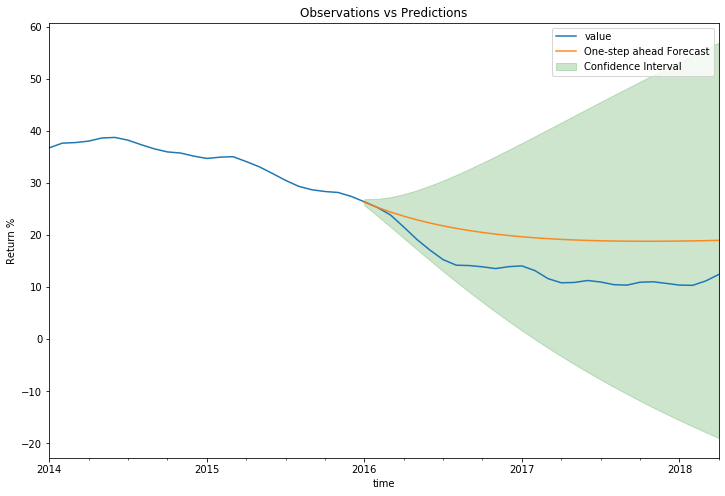

The RMSE of our forecast is 6.74.



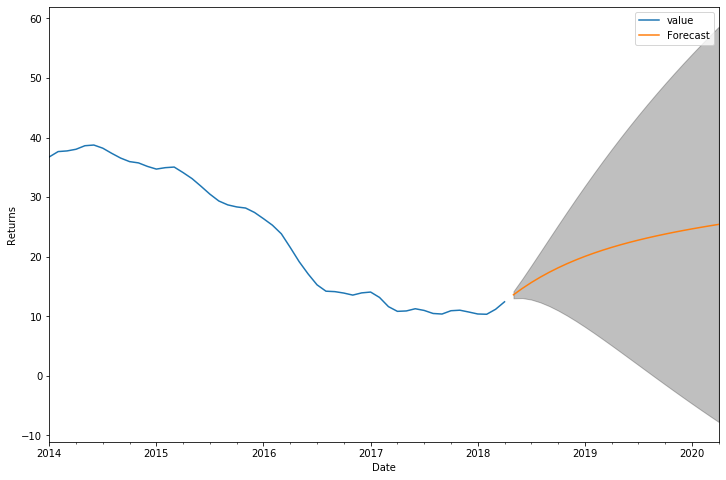

          Return at End of Forecast
forecast                  25.433882
maximum                   58.608369
minimum                   -7.740605


In [44]:
sf2_predictions = get_predictions(sf_roi2, sf2_output)

Our initial model predicts that within 2 years from the end of our data, the return for investment for those who had invested 2 years prior would be of about 24%, but the wide confidence intervals put this return ranging from -9% to 57%.

This is a large interval for our prediction and wouldn't help much our stakeholders with their decision. Let's try to fit a model using the parameters that we could infer from our ACF and PACF plots and see how it performs.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:              SARIMAX(3, 1, 14)   Log Likelihood                  16.233
Date:                Sat, 02 May 2020   AIC                              7.534
Time:                        20:47:23   BIC                             77.147
Sample:                    04-01-1998   HQIC                            35.583
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.101      0.026      0.980      -0.195       0.200
drift       7.153e-06      0.001      0.012      0.990      -0.001       0.001
ar.L1          1.4815      1.050      1.411      0.1

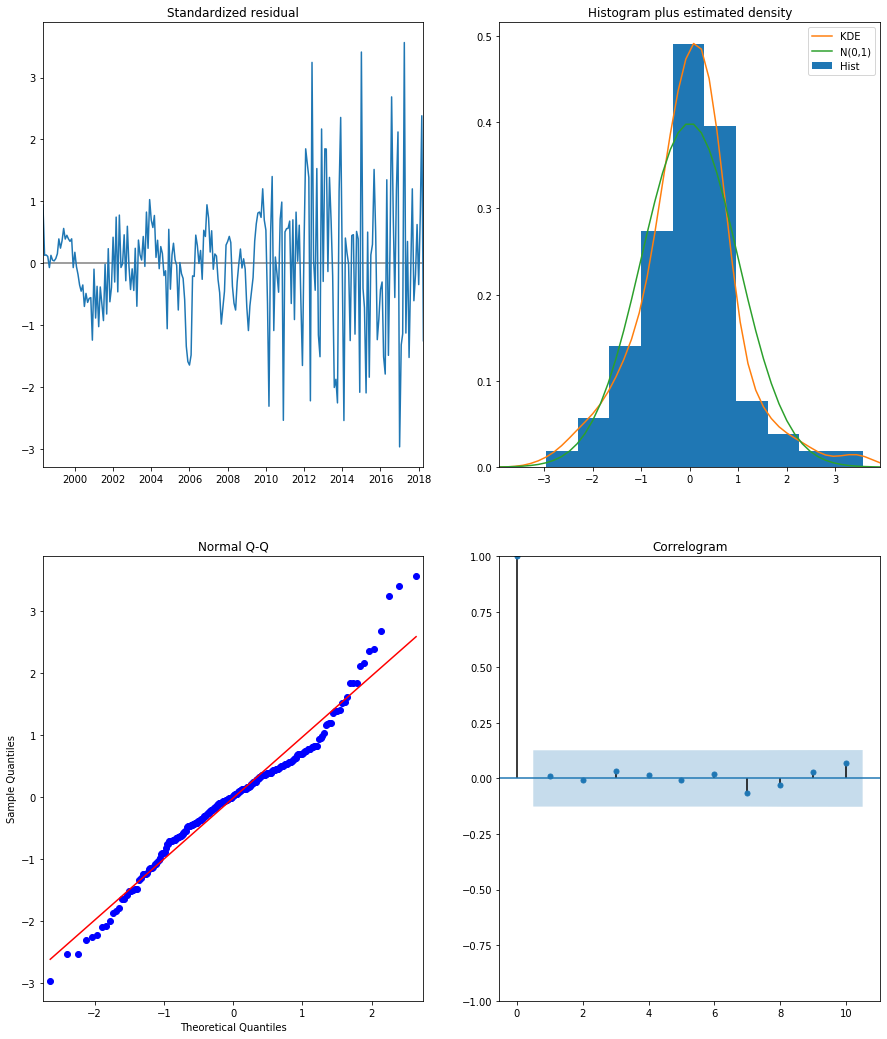

In [45]:
sf2_output2 = fit_sarimax_model(sf_roi2, order=(3, 1, 14), seasonal_order=(0, 0, 0, 12))

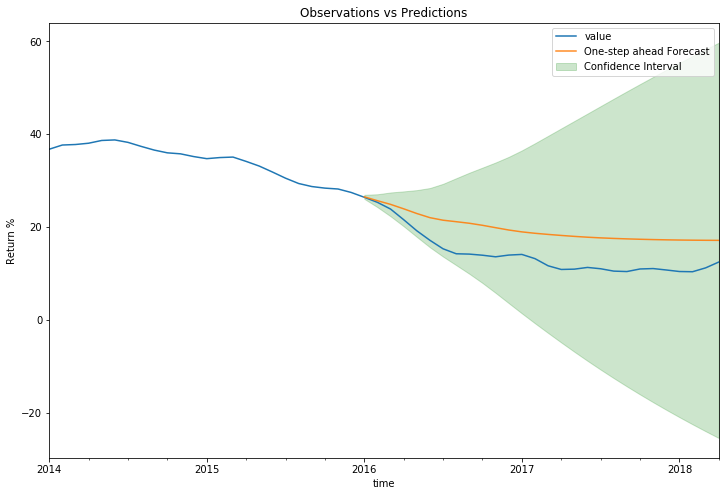

The RMSE of our forecast is 5.81.



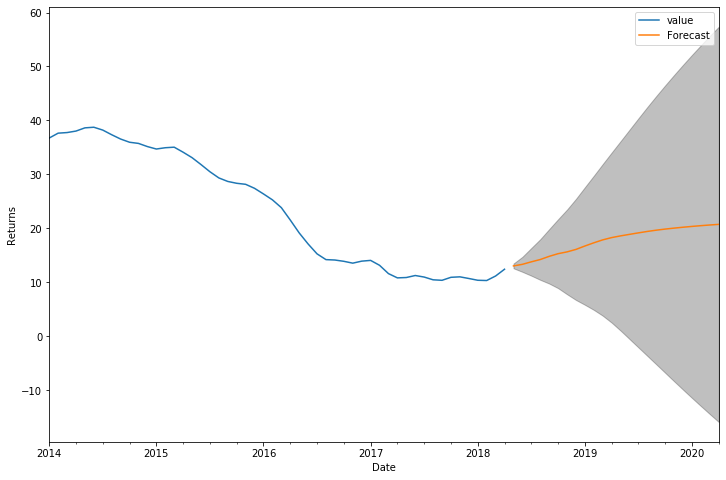

          Return at End of Forecast
forecast                  20.750535
maximum                   57.376471
minimum                  -15.875401


(20.75053511269653, 57.37647130222608, -15.875401076833025)

In [46]:
get_predictions(sf_roi2, sf2_output2)

Our AIC is much smaller, and the RMSE is also smaller. Let's see if we can continue to improve our model with some automationn for the ideal orders and differencing term.

We will use the function auto_arima, which performs a search over possible orders and helps us select the parameters that minimize a given metric. In this case we are using the AIC (Akaike Information Criterion) value to measure the quality of our model.

We will input the maximum parameters that we could infer from our ACF and PACF plots, and leave the function to estimate automatically the differencing term and orders.

(You can learn more about the auto_arima [here](http://www.alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html).)

In [47]:
# define a function to run auto arima and search for best model parameters
def find_orders(ts):
    
    '''Takes a time series and finds the best differencing order, as well as the other best
    parameters for a SARIMAX model using auto_arima'''
    
    stepwise_model = pm.auto_arima(ts, start_p=1, start_q=1, max_p=4, max_q=14,
                                m=12, seasonal=True, stationary=False,
                                stepwise=True, trend='ct',
                                suppress_warnings=True, trace=False, 
                                error_action='ignore')
   
    return stepwise_model.order, stepwise_model.seasonal_order

In [48]:
find_orders(sf_roi2)

((1, 1, 3), (1, 0, 2, 12))

Great! Now let's fit our model again using these parameters provided and see how we perform.

                                        SARIMAX Results                                        
Dep. Variable:                                   value   No. Observations:                  241
Model:             SARIMAX(2, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood                  25.779
Date:                                 Sat, 02 May 2020   AIC                            -31.558
Time:                                         20:48:16   BIC                              3.249
Sample:                                     04-01-1998   HQIC                           -17.533
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0012      0.021     -0.056      0.955      -0.042       0

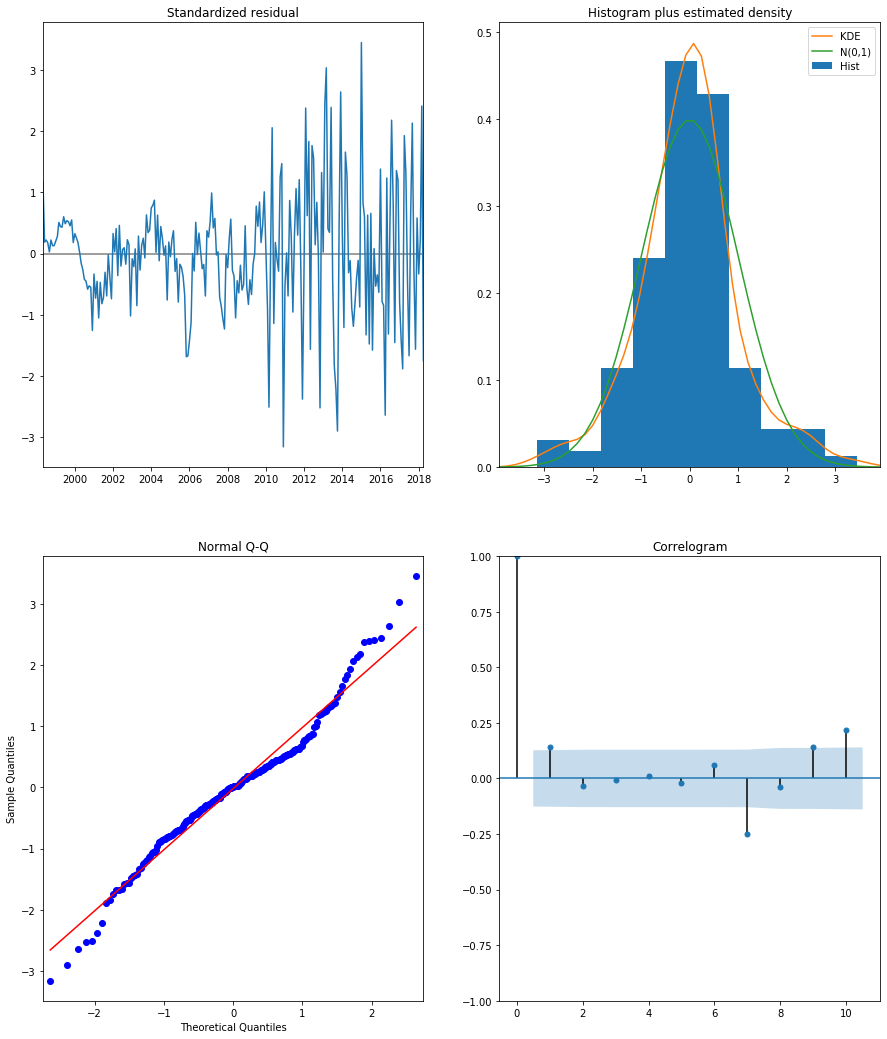

In [49]:
sf2_output3 = fit_sarimax_model(sf_roi2, order=(2, 1, 3), seasonal_order=(0, 0, 2, 12))

This model does seem better. We have a much lower AIC than our base, and the residuals look a bit more normally distributed. Let's verify what predictions and errors we get with this new model.

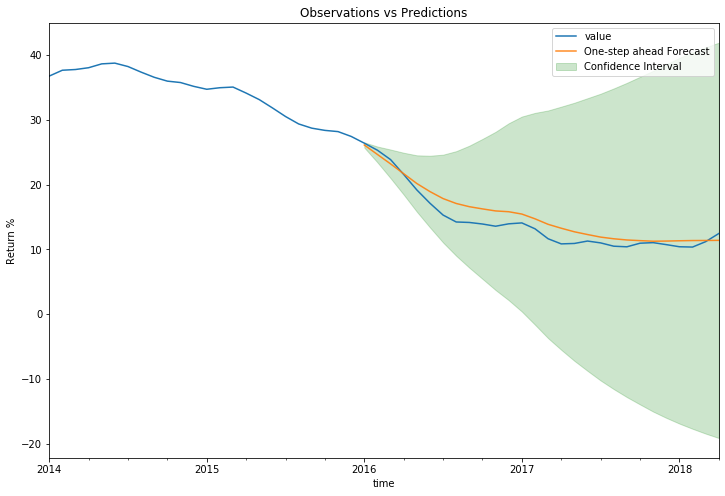

The RMSE of our forecast is 1.54.



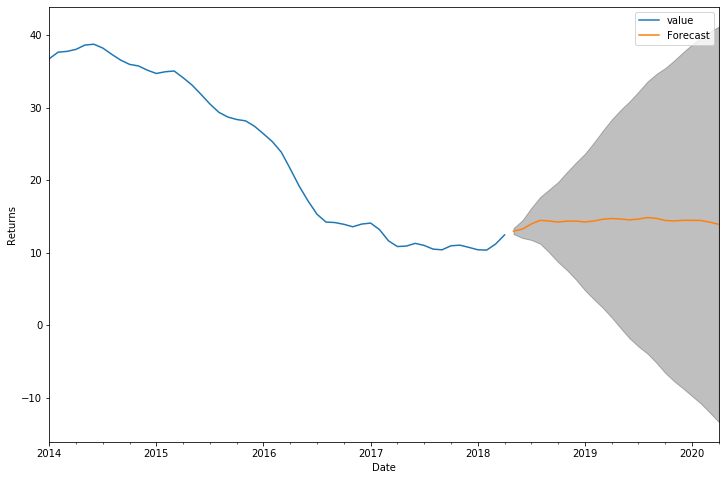

          Return at End of Forecast
forecast                  13.894787
maximum                   41.165079
minimum                  -13.375505


In [50]:
sf2_predictions = get_predictions(sf_roi2, sf2_output3)

This model indeed seems like it does a better job than our previous tries. The RMSE for our forecast is much smaller and our prediction range is not as wide, with a 9.4% return predicted, possibly ranging from -18% to 37% at a 95% confidence interval.

Let's store this result in a dictionary and repeat this process for our other 3 time series.

In [51]:
predictions = {}
predictions['San Francisco 2-year'] = sf2_predictions

In [52]:
predictions

{'San Francisco 2-year': (13.89478697387088,
  41.165078920413606,
  -13.375504972671843)}

In [53]:
find_orders(nyc_roi2)

((1, 1, 1), (2, 0, 0, 12))

                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 12)   Log Likelihood                 -50.815
Date:                             Sat, 02 May 2020   AIC                            115.630
Time:                                     20:48:34   BIC                            135.967
Sample:                                 01-01-2007   HQIC                           123.895
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1371      0.107     -1.283      0.199      -0.346       0.072
drift          0.0016      

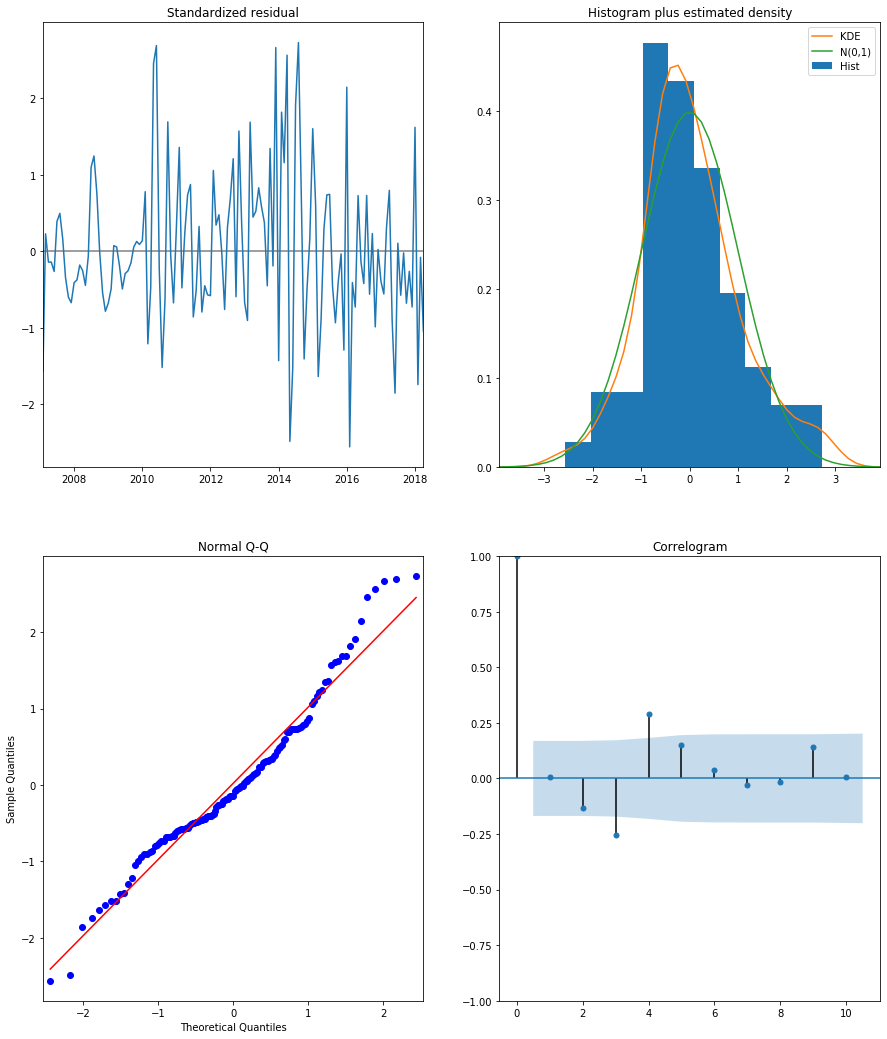

In [54]:
nyc2_output = fit_sarimax_model(nyc_roi2, order=(1, 1, 1), seasonal_order=(2, 0, 0, 12))

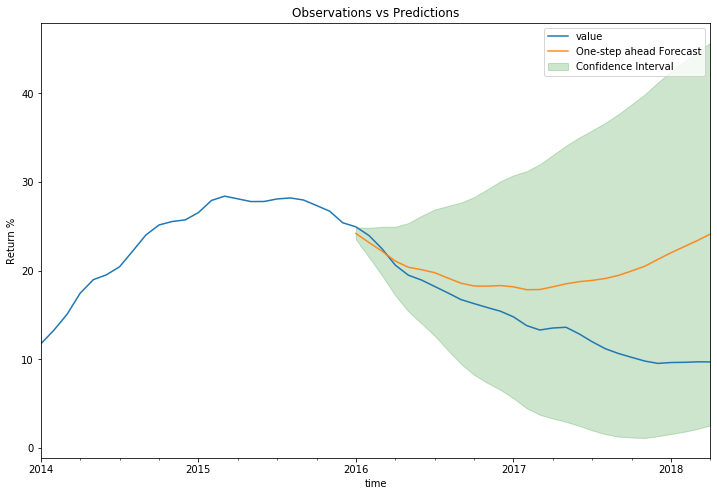

The RMSE of our forecast is 7.1.



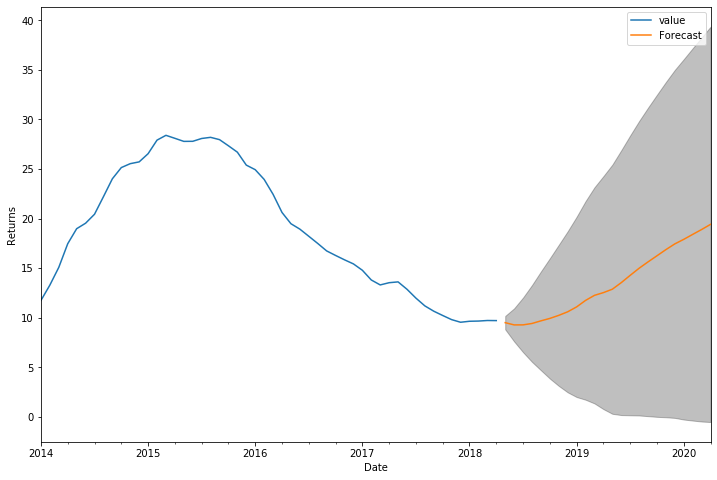

          Return at End of Forecast
forecast                  19.416146
maximum                   39.363035
minimum                   -0.530743


In [55]:
nyc2_predictions = get_predictions(nyc_roi2, nyc2_output)

Our RMSE for the New York time series is not as low as the one for San Francisco. In any case making time series predictions is tricky business and we trust this is the best model we can achieve for now. Let's save our results to our dictionary and move on to San Francisco 5-year returns.

In [56]:
predictions['New York 2-year'] = nyc2_predictions

In [57]:
find_orders(sf_roi5)

((1, 2, 3), (2, 0, 2, 12))

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  205
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 -49.099
Date:                Sat, 02 May 2020   AIC                            110.197
Time:                        20:49:31   BIC                            130.076
Sample:                    04-01-2001   HQIC                           118.239
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0209      0.102      0.205      0.837      -0.179       0.221
drift         -0.0003      0.001     -0.502      0.616      -0.002       0.001
ar.L1          0.3230      0.049      6.580      0.0

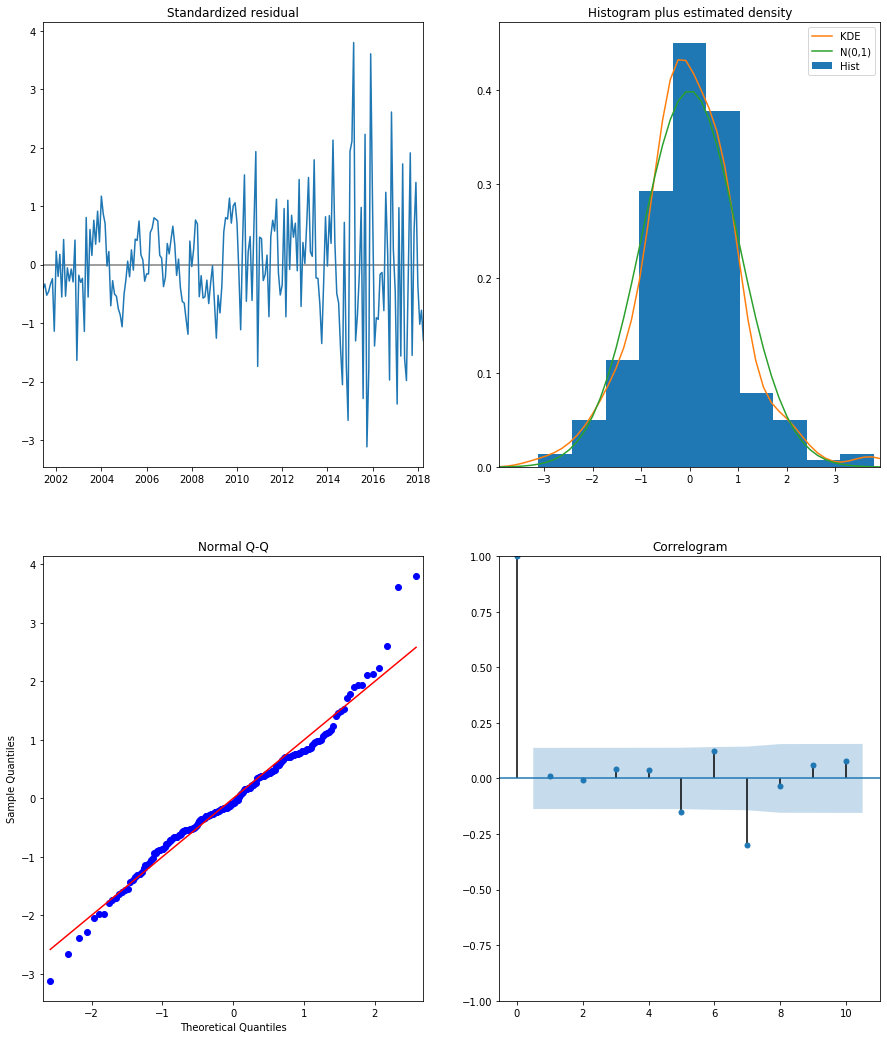

In [58]:
sf5_output = fit_sarimax_model(sf_roi5, order=(2, 2, 1), seasonal_order=(0, 0, 0, 12))

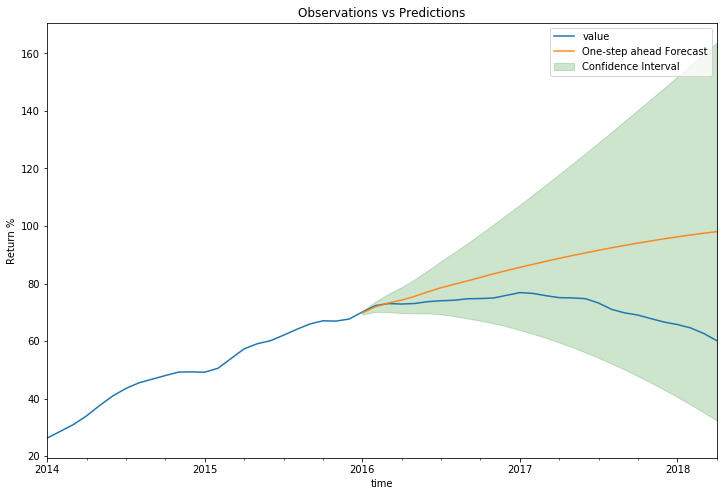

The RMSE of our forecast is 18.37.



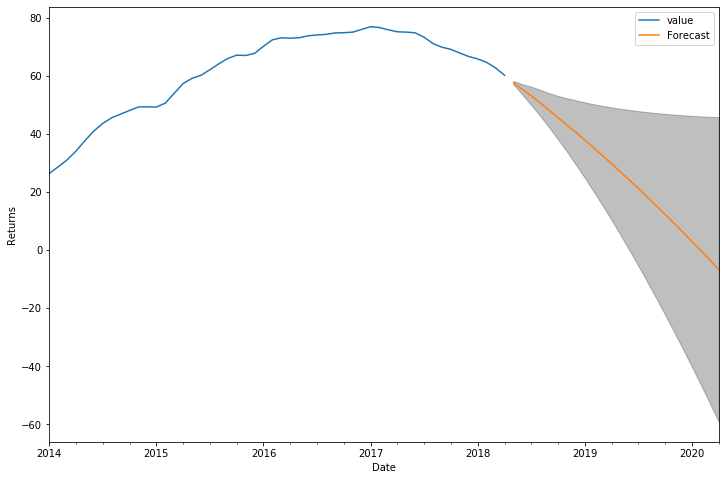

          Return at End of Forecast
forecast                  -6.724150
maximum                   45.734655
minimum                  -59.182955


In [59]:
sf5_predictions = get_predictions(sf_roi5, sf5_output)

We can see that our results for San Francisco on a 5-year lag are much more prone to error and present a much wider confidence interval. This is to be expected for longer periods of predictions. We can note that our model predicts the continuation of fall in returns for 5-year investments in San Francisco.

In [60]:
predictions['San Francisco 5-year'] = sf5_predictions

In [61]:
find_orders(nyc_roi5)

((0, 2, 1), (0, 0, 0, 12))

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  112
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -138.561
Date:                Sat, 02 May 2020   AIC                            285.122
Time:                        20:49:34   BIC                            295.924
Sample:                    01-01-2009   HQIC                           289.503
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0420      0.119     -0.353      0.724      -0.275       0.191
drift          0.0003      0.002      0.149      0.881      -0.004       0.004
ma.L1         -0.3451      0.053     -6.498      0.0

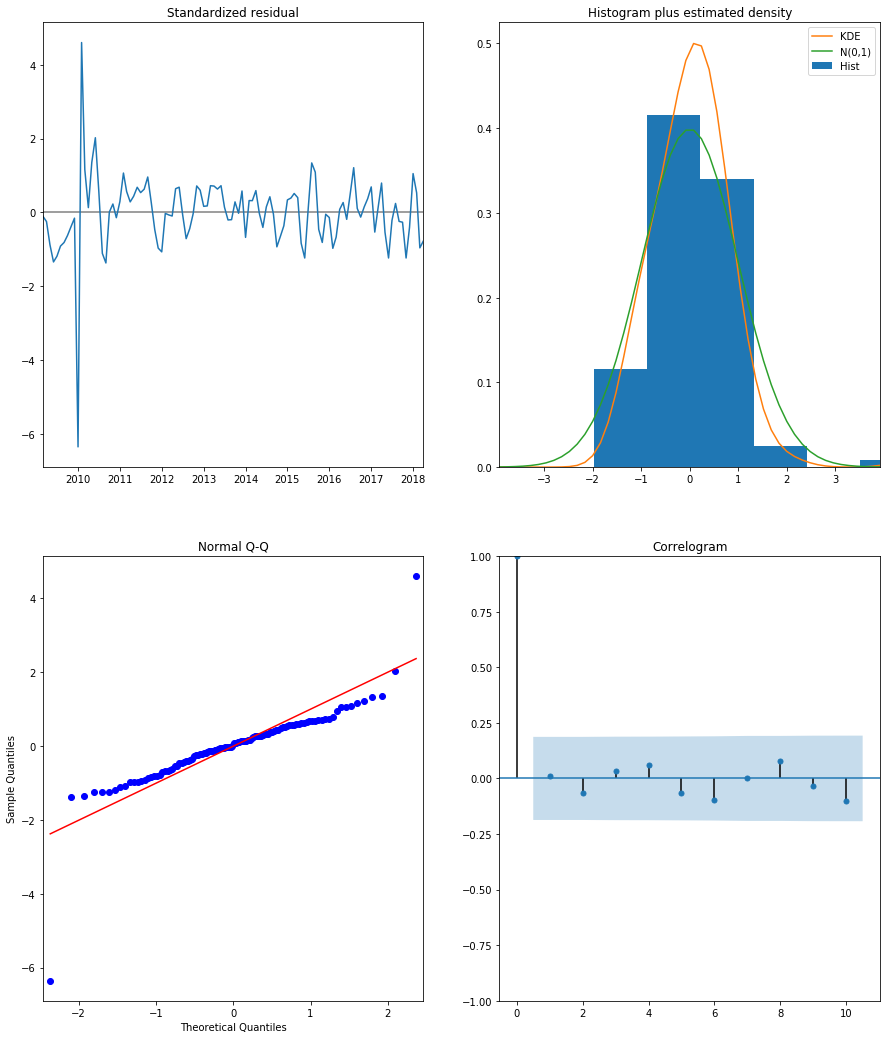

In [62]:
nyc5_output = fit_sarimax_model(nyc_roi5, order=(0, 2, 1), seasonal_order=(0, 0, 0, 12))

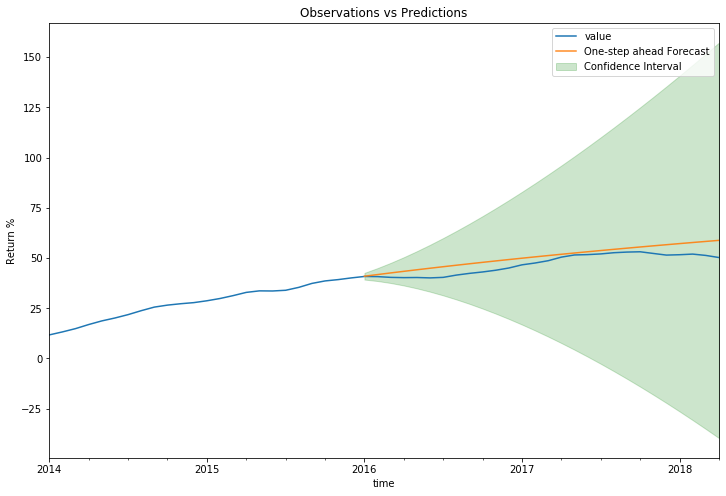

The RMSE of our forecast is 4.07.



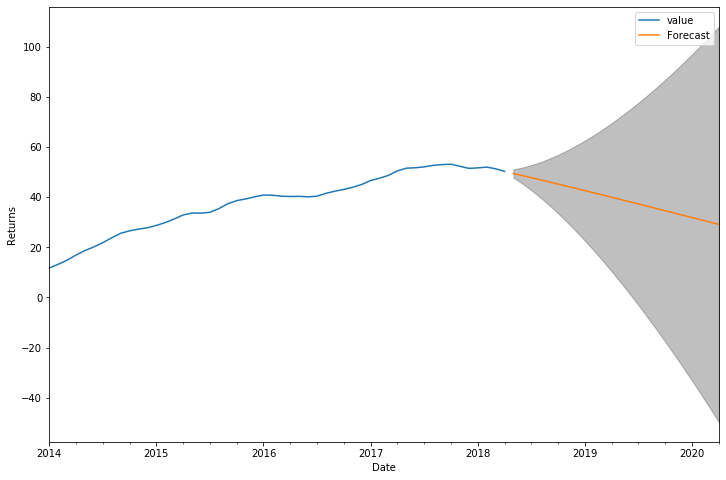

          Return at End of Forecast
forecast                  29.132010
maximum                  107.930263
minimum                  -49.666244


In [63]:
nyc5_predictions = get_predictions(nyc_roi5, nyc5_output)

In [64]:
predictions['New York 5-year'] = nyc5_predictions

In [65]:
# format data into dataframe
results = pd.DataFrame.from_dict(predictions, orient='index', columns=['Predicted Return', 'Maximum Return', 'Minimum Return'])
results

Predicted Return  Maximum Return  Minimum Return
San Francisco 2-year         13.894787       41.165079      -13.375505
New York 2-year              19.416146       39.363035       -0.530743
San Francisco 5-year         -6.724150       45.734655      -59.182955
New York 5-year              29.132010      107.930263      -49.666244

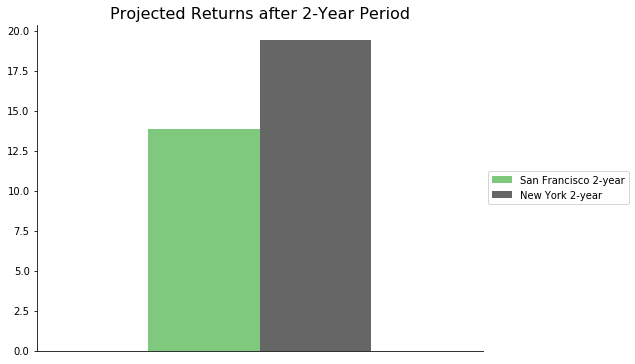

In [66]:
# plot results
ax = results.iloc[:2,:1].transpose().plot(kind='bar', colormap='Accent', figsize=(8,6))
plt.title('Projected Returns after 2-Year Period', fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.xticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

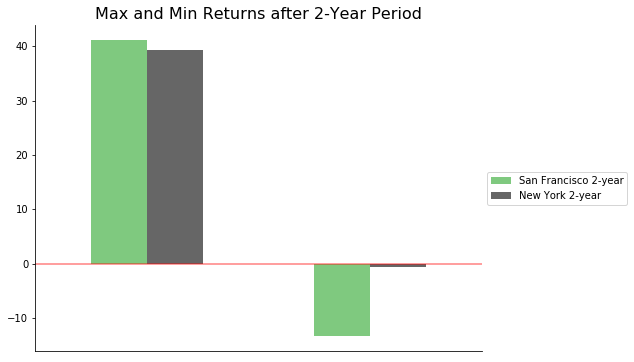

In [67]:
# plot results
ax = results.iloc[:2,1:].transpose().plot(kind='bar', colormap='Accent', figsize=(8,6))
plt.axhline(y=0, color='red', alpha=.5)
plt.title('Max and Min Returns after 2-Year Period', fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.xticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

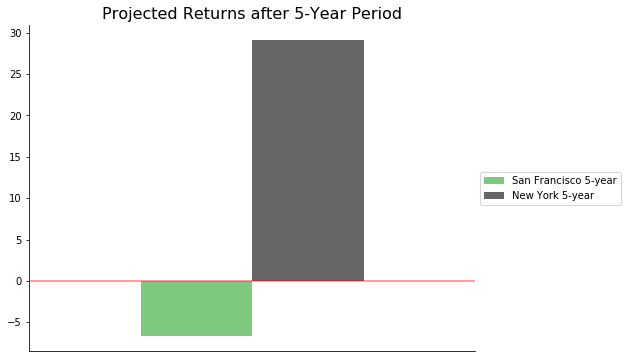

In [68]:
# plot results
ax = results.iloc[2:,:1].transpose().plot(kind='bar', colormap='Accent', figsize=(8,6))
plt.title('Projected Returns after 5-Year Period', fontsize=16)
plt.axhline(y=0, color='red', alpha=.5)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.xticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

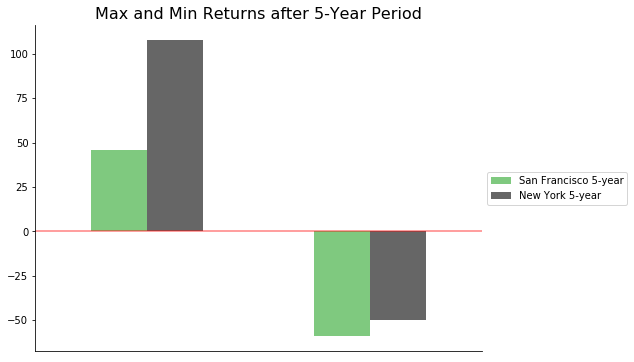

In [69]:
# plot results
ax = results.iloc[2:,1:].transpose().plot(kind='bar', colormap='Accent', figsize=(8,6))
plt.axhline(y=0, color='red', alpha=.5)
plt.title('Max and Min Returns after 5-Year Period', fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.xticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

What we want to do now is to streamline this process and apply it to all our time series so that we can compare which one is the best. Let's create functions to do all this at once.

In [70]:
# create function to compare 2-year returns
def compare_2y_roi(ts_list, names_list, plot=True):
    
    '''
    Takes a list of time series and its names and returns forecasted returns, along with
    confidence interval values for a 2-year in time prediction in a dataframe format.
    '''
    # create dictionary to store results
    hist_roi = {}   
    
    # model and get predictions
    for ts, name in zip(ts_list, names_list):
        hist_roi[name] = {}
        order, seasonal_order = find_orders(ts)
        model = fit_sarimax_model(ts, order=order, seasonal_order=seasonal_order, summary=False, plot=False)
        forecast, maximum, minimum = get_predictions(ts, model, plot=False, show=False)
        hist_roi[name]['Predicted Return'] = forecast
        hist_roi[name]['Maximum Return'] = maximum
        hist_roi[name]['Minimum Return'] = minimum
    
    # format data into dataframe
    results = pd.DataFrame.from_dict(hist_roi)
    
    # plot results
    if plot:
        ax = results.plot(kind='bar', colormap='Accent', figsize=(8,6))
        plt.axhline(y=0, color='red', alpha=.5)
        plt.title('Projected Returns after 2-Year Period', fontsize=16)
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        plt.gcf().autofmt_xdate()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    print(results)
    return results
        

In [71]:
# define another function for a 5-Year time return
def compare_5y_roi(ts_list, names_list, plot=True):
        
    '''
    Takes a list of time series and its names and returns forecasted returns, along with
    confidence interval values for a 5-year in time prediction in a dataframe format.
    '''
    # create dictionary to store results
    hist_roi = {}
    
    # model and get predictions
    for ts, name in zip(ts_list, names_list):
        hist_roi[name] = {}
        order, seasonal_order = find_orders(ts)
        model = fit_sarimax_model(ts, order=order, seasonal_order=seasonal_order, summary=False, plot=False)
        forecast, maximum, minimum = get_predictions(ts, model, plot=False, show=False)
        hist_roi[name]['Predicted Return'] = forecast
        hist_roi[name]['Maximum Return'] = maximum
        hist_roi[name]['Minimum Return'] = minimum
        
    # format data into dataframe
    results = pd.DataFrame.from_dict(hist_roi)
    
    # plot results
    if plot:
        ax = results.plot(kind='bar', colormap='Accent', figsize=(8,6))
        plt.axhline(y=0, color='red', alpha=.5)
        plt.title('Projected Returns after 5-Year Period', fontsize=16)
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        plt.gcf().autofmt_xdate()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    print(results)
    return results

                  San Francisco  New York City
Predicted Return      17.922058      19.416146
Maximum Return        44.783581      39.363035
Minimum Return        -8.939464      -0.530743


San Francisco  New York City
Predicted Return      17.922058      19.416146
Maximum Return        44.783581      39.363035
Minimum Return        -8.939464      -0.530743

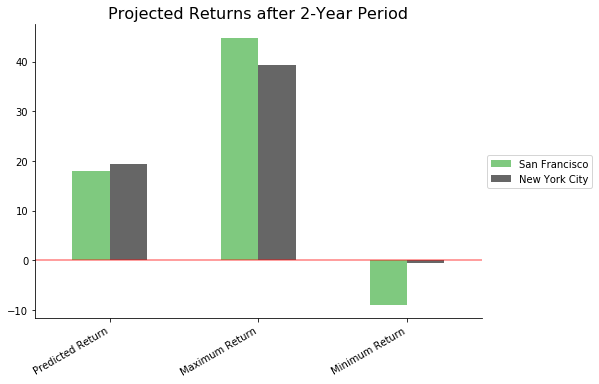

In [72]:
ts_2year = [sf_roi2, nyc_roi2]
names_2year = ['San Francisco', 'New York City']
forecast_2years = compare_2y_roi(ts_2year, names_2year)
forecast_2years

This is a very interesting result! The past data had shown us that New York City has been consistently a better city to invest in real estate when compared to San Francisco, regardless of the horizon of the return: 2, 5 or 10 years. However, the most recent data from our time series had shown San Francisco returns above those of from NYC. We wanted to see if this was a trend that would be sustained in the future for our stakeholders, making San Francisco a more interesting investment option in despite of New York historical superior gains.

What our model results show us is that if our stakeholders are looking to buy and sell within 2 years, New York City shows the best gain prediction. Although NYC maximum potential gain is similar to San Francisco's, the later representes a larger potential loss. We can conclude that New York City offers more gain potential and presents less risk for that time frame of 2 years. 

                  San Francisco  New York City
Predicted Return      -6.914400      29.132010
Maximum Return        38.737596     107.930263
Minimum Return       -52.566396     -49.666244


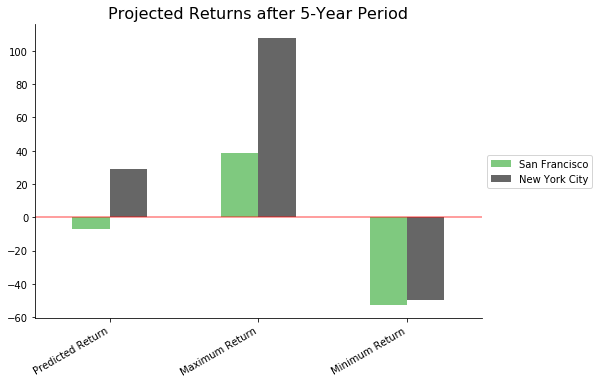

In [73]:
ts_5year = [sf_roi5, nyc_roi5]
names_5year = ['San Francisco', 'New York City']
forecast_5years = compare_5y_roi(ts_5year, names_5year)

Again, when the timespan for the investment extends to 5 years, the predictions for San Francisco are not looking so good. There is a loss predicted for San Francisco, and it could potentially be as large as almost 60%. New York City, although also with a possibility of relatively high loss at the lowest end of our confidence interval, nonetheless looks like a more consistent investment option, with better predicted and potential high gains when the time of investment is of 5 years.

In conclusion:

### **For a 2-Year Investment: New York City**

### **For a 5-Year Investment: New York City**

Ok, now that we have some recommendations for our stakeholders in terms of which city to invest, let's move on to the second part of the project and find the best 5 zipcodes in each location to invest on.

## Part II - Best Zipcodes to Invest

Besides the overal analysis comparing these two cities, we also want to recommend what are the best zipcodes to buy real estate in each place. For that we will create a dictionary with the time series data for all zipcodes from both cities so that we have access to the data for all zipcodes in order to model.

In [74]:
# Dictionary to include all zip code time series
sf_zip_dict = {}
    
# Iterate over all the zip codes within each city
for z in san_francisco.Zipcode.unique():
    
    # Choosing that specific zip code
    temp_zip_df = san_francisco[san_francisco.Zipcode == z]

    # Creating a time series (via melting) for that zip code
    temp_zip_ts = melt_data(temp_zip_df)

    # Adding that time series to a dictionary
    sf_zip_dict[z] = temp_zip_ts


In [75]:
# we can now access each zip code by the keys
sf_zip_dict.keys()

dict_keys([94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114, 94103, 94107, 94116, 94123, 94131, 94133, 94134, 94132, 94124, 94127])

In [76]:
sf_zip_dict[94109].head()

value
time                
1996-04-01  766000.0
1996-05-01  771100.0
1996-06-01  776500.0
1996-07-01  781900.0
1996-08-01  787300.0

In [77]:
# we can also plot them
fig = go.Figure()
for i, key in enumerate(sf_zip_dict):
    fig.add_trace(go.Scatter(x=sf_zip_dict[key].index, y=sf_zip_dict[key].value, name=str(list(sf_zip_dict.keys())[i-1])))
fig.update_layout(title_text='San Francisco Zillow Home Value Index (ZHVI)',
                      xaxis_rangeslider_visible=False, showlegend=False)
fig.show()

We can see that some zip codes did suffer more harshly from the crisis, which can indicate higher risk for investments. We can also note that the rising trend is more accute for some zip codes when compared to others, which could lead to higher ROIs for the short/medium timeframe. 

Let's do the same thing for the New York City zip codes, generating the time series for each one and saving it all into a dictionary.

In [78]:
# repeat with nyc data:
nyc_zip_dict = {}
    
# Iterate over all the zip codes within each city
for z in nyc.Zipcode.unique():
    
    # Choosing that specific zip code
    temp_zip_df = nyc[nyc.Zipcode == z]

    # Creating a time series (via melting) for that zip code
    temp_zip_ts = melt_data(temp_zip_df)

    # Adding that time series to a dictionary
    nyc_zip_dict[z] = temp_zip_ts

In [79]:
# plot zipcodes data all together
fig = go.Figure()
for i, key in enumerate(nyc_zip_dict):
    fig.add_trace(go.Scatter(x=nyc_zip_dict[key].index, y=nyc_zip_dict[key].value, name=str(list(nyc_zip_dict.keys())[i-1])))
fig.update_layout(title_text='New York Zillow Home Value Index (ZHVI)',
                      xaxis_rangeslider_visible=False, showlegend=False)
fig.show()

Interesting plot that we should never show to a stakeholder. In any case it reminds us that some NYC zipcodes were created later on. Let's remove all NaNs from our data so that we don't encounter any problems with our modeling further ahead.

In [80]:
# drop NaNs
for key in nyc_zip_dict:
    nyc_zip_dict[key].dropna(inplace=True, axis=0)

In [81]:
# check data
nyc_zip_dict[11223].isna().sum()

value    0
dtype: int64

All right, now we need some functions to do the heavy lifting for us. We want to calculate the 2-Year and the 5-Year return for each of these zipcodes, and then select the 5 with the highest mean last 6 months returns.  
 
Let's start with those functions, and we will use some of the functions that we have created previously as well.

In [82]:
def calculate_returns(dictionary_of_zipcodes, years=0):
    
    '''Takes dictionary of zipcodes and number of years as parameters, calculates ROI for 2 or 5 number of years
    and returns dictionary with ROI data instead of house price data.'''
    
    if years==2:
        # calculate 2 year returns
        returns = {}
        for i, key in enumerate(dictionary_of_zipcodes):
            temp_return = (dictionary_of_zipcodes[key] - dictionary_of_zipcodes[key].shift(periods=24))/dictionary_of_zipcodes[key].shift(periods=24)*100
            temp_return.dropna(inplace=True)
            returns[list(dictionary_of_zipcodes.keys())[i-1]] = temp_return
            
        return returns
    
    if years==5:
        # calculate 5 year returns
        returns = {}
        for i, key in enumerate(dictionary_of_zipcodes):
            temp_ts = (dictionary_of_zipcodes[key] - dictionary_of_zipcodes[key].shift(periods=60))/dictionary_of_zipcodes[key].shift(periods=60)*100
            temp_ts.dropna(inplace=True)
            returns[list(dictionary_of_zipcodes.keys())[i-1]] = temp_ts
            
        return returns

In [83]:
def filter_zipcodes(returns_dict, years=0, city=''):
    
    '''Takes dictionary with zipcodes and filters to the 5 ones with highest mean
    ROI for the last 6 months of data.'''
    
    # filter only 15 highest current return zipcodes
    temp_dict = {}
    for i, key in enumerate(returns_dict):
        temp_dict[list(returns_dict.keys())[i-1]] = returns_dict[key].iloc[-7:-1].values.mean()#calculating mean return for last 6 months
           
    return_6months = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Mean 6M Return'])
    return_6months = return_6months.nlargest(5, ['Mean 6M Return']) #taking the 5 largest returns
    return_6months = pd.DataFrame(return_6months) #from array to dataframe format again
    return_6months = return_6months.transpose()
    
    
    # plot results
    zipcodes = [z for z in return_6months.index]
    y_pos = np.arange(len(zipcodes))
    ax = return_6months.plot.bar(align='center', colormap='summer')
    plt.axhline(y=0, color='red', alpha=.5)
    plt.title(f'Best {city} Zipcodes to Invest for {years}-Year Period', fontsize=16)
    ax.set_ylabel('Mean 6m Gain Percentage')
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    plt.xticks([])
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # print returns for each zipcode
    print(return_6months)
    
    # filter complete data for final zips for model and prediction
    #final_zips = dict((k, returns_dict[k]) for k in list(return_6months.columns))#filtering dict for selected zips
    
    return return_6months

Great, now that we have our functions ready to help us, let's use them. We will start with San Francisco's zipcodes for an investment lag of 2 years.

In [84]:
# calculate 2-year returns for all San Francisco zipcodes
sf_2years_returns = calculate_returns(sf_zip_dict, years=2)

In [85]:
# check our results
sf_2years_returns[94110].head()

value
time                 
1998-04-01  25.826149
1998-05-01  27.164930
1998-06-01  28.304598
1998-07-01  29.124821
1998-08-01  29.778096

                    94133      94114      94109      94103      94131
Mean 6M Return  26.653924  22.863499  18.865613  18.410506  18.384825


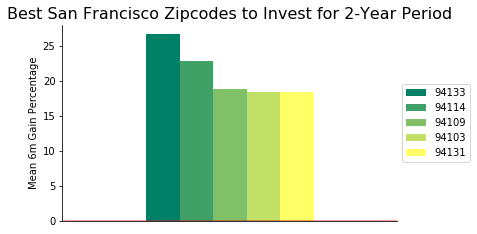

In [86]:
# filter the zipcodes with the highest mean return for last 6 months 
sf_2years_filtered = filter_zipcodes(sf_2years_returns, years=2, city='San Francisco')

In [87]:
# calculate 2-year returns for all New York City zipcodes
nyc_2years_returns = calculate_returns(nyc_zip_dict, years=2)

In [88]:
# check our results
nyc_2years_returns[10011].head()

value
time                 
1998-04-01  13.177578
1998-05-01  11.767723
1998-06-01  10.204848
1998-07-01   8.496245
1998-08-01   6.684648

                    11230      10462      10312     11367      11223
Mean 6M Return  36.747737  32.841348  32.481327  30.53634  30.160188


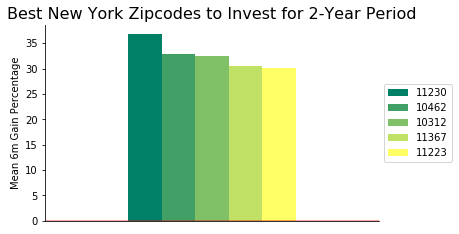

In [89]:
# filter the zipcodes with the highest mean return for last 6 months 
nyc_2years_filtered = filter_zipcodes(nyc_2years_returns, years=2, city='New York')

In [90]:
# calculate 5-year returns for all San Francisco zipcodes
sf_5years_returns = calculate_returns(sf_zip_dict, years=5)

In [91]:
# check our results
sf_5years_returns[94110].head()

value
time                 
2001-04-01  89.224138
2001-05-01  89.220266
2001-06-01  89.188218
2001-07-01  89.096126
2001-08-01  89.083751

                     94134      94114      94115      94127      94118
Mean 6M Return  108.379999  95.149122  91.310032  86.868929  83.834897


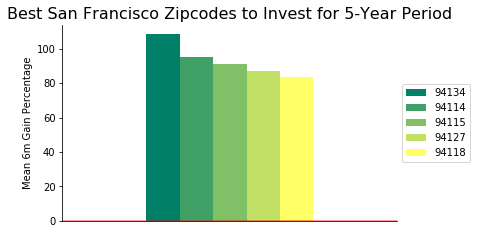

In [92]:
# filter the zipcodes with the highest mean return for last 6 months 
sf_5years_filtered = filter_zipcodes(sf_5years_returns, years=5, city='San Francisco')

In [93]:
# calculate 5-year returns for all New York City zipcodes
nyc_5years_returns = calculate_returns(nyc_zip_dict, years=5)

In [94]:
# check our results
nyc_5years_returns[10011].head()

value
time                 
2001-04-01 -16.811271
2001-05-01 -16.751255
2001-06-01 -16.696160
2001-07-01 -16.614286
2001-08-01 -16.449839

                     11203       11106       11212       11373       11385
Mean 6M Return  147.574577  121.081128  116.095907  114.519571  102.183975


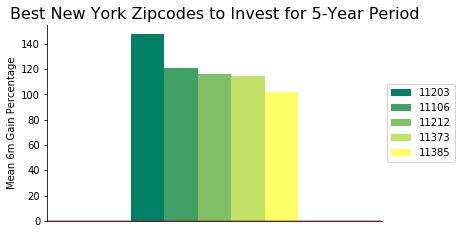

In [95]:
# filter the zipcodes with the highest mean return for last 6 months 
nyc_5years_filtered = filter_zipcodes(nyc_5years_returns, years=5, city='New York')

## Conclusions and Recommendations

Our stakeholders were interested in investing in real estate either in San Francisco, CA or in New York City, NY. They were looking to find our what was the location that would offer better ROI over a 2-year and a 5-year time invested.

We conducted a time series analysis and modeling based on data from Zillow Research Page, which provides us with the mean Zillow Home Value Index for several years and many zipcodes from both cities. 

Based on our analysis of historical data and on predictions obtained from our models, and from the first part of the project, we would recommend the following:

## **2-Year Investments: New York City**<br>
   
   ### 5 Best New York City Zipcodes for 2-year Investment:  
   
   11230, 10462, 10312, 11367, 11223 
   
   #### 5 Best San Francisco Zipcodes for 2-year Investment: 
   
   94133, 94114, 94109, 94103, 94131
   

   
## **5-Year Investments: New York City** <br>
   
   ### 5 Best New York City Zipcodes for 2-year Investment:  
   
   11203, 11106, 11212, 11373, 11385
   
   #### 5 Best San Francisco Zipcodes for 2-year Investment: 
   
   94134, 94114, 94115, 94127, 94118

## Future Work

For future work we could explore other cities, as well as continue to improve our model by trying to deepen our understanding of the data and trends and continue to tweak and improve our prediction model. 

We could also experiment with other types of time series models such as Facebook Prophet, Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX), or Holt Winter’s Exponential Smoothing (HWES), for example

